# Build regression model from formation signals

Create a simple linear regression model that maps formation signals to end-of-life features.

Created: 4/18/2021

Author: Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm, colors
from matplotlib import pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

import ipdb

from src.formation import FormationCell
from src.utils import get_label_registry

# Make sure user is in the right directory
assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
def config_plots():
    # Configure plot settings
    plt.rc('font', **{'family'     : 'sans-serif',
                      'sans-serif' : ['Arial'],
                      'size': 18
                      })
    plt.rc('figure', **{'autolayout' : True,
                        'figsize'    : (7, 5),
                        'facecolor'  : 'white',
                        'dpi'        : 150
                        })
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('axes',  labelsize='medium', grid=False)
    plt.rc('axes',  titlesize='medium')
    plt.rc('legend', fontsize='medium')

config_plots()
cmap = cm.get_cmap('Set1', 10)

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = 'k'
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = 'b'
COLOR_FAST_HT = 'r'
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = 'b'
COLOR_NEG = 'r'
COLOR_FULL_CELL = 'k'

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Point to the dataset

In [5]:
DATA_INPUT_PATH = 'output/correlation_data.csv';

assert os.path.isfile(DATA_INPUT_PATH), "Input data file is missing or is in the wrong directory."

## Load the correlation data

In [6]:
df = pd.read_csv(DATA_INPUT_PATH)

df = df[df['cellid'] != 9] # tab weld issue cell; exclude from entire study

# A single cell had a blatantly unphysical voltage fitting result; exclude this
df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan 

# Add total lithium consumed feature
df['form_total_lithium_consumed'] = df['form_first_charge_capacity_ah'] - df['form_final_discharge_capacity_ah']

# Cycle indices corresponding to RPTs, plus one at the beginning for "formation"
cyc_idx_rpt_arr = [1, 3, 56, 159, 262, 365]

# Separate room temp and hot
df_room = df[df['is_room_temp_aging'] == 0]
df_hot = df[df['is_room_temp_aging'] == 1]
df = df_room

# Here are the available features
for feature in sorted(df.columns):
    print(feature)

Unnamed: 0
c20_dch_cap_at_c159_ah
c20_dch_cap_at_c262_ah
c20_dch_cap_at_c365_ah
c20_dch_cap_at_c3_ah
c20_dch_cap_at_c418_ah
c20_dch_cap_at_c468_ah
c20_dch_cap_at_c471_ah
c20_dch_cap_at_c521_ah
c20_dch_cap_at_c524_ah
c20_dch_cap_at_c56_ah
c20_dch_cap_at_c574_ah
c20_dch_cap_at_c577_ah
c20_dch_cap_at_c630_ah
c20_minus_c3_dch_cap_at_c159_ah
c20_minus_c3_dch_cap_at_c262_ah
c20_minus_c3_dch_cap_at_c365_ah
c20_minus_c3_dch_cap_at_c3_ah
c20_minus_c3_dch_cap_at_c418_ah
c20_minus_c3_dch_cap_at_c468_ah
c20_minus_c3_dch_cap_at_c471_ah
c20_minus_c3_dch_cap_at_c521_ah
c20_minus_c3_dch_cap_at_c524_ah
c20_minus_c3_dch_cap_at_c56_ah
c20_minus_c3_dch_cap_at_c574_ah
c20_minus_c3_dch_cap_at_c577_ah
c20_minus_c3_dch_cap_at_c630_ah
c20_over_c3_dch_cap_at_c159_ah
c20_over_c3_dch_cap_at_c262_ah
c20_over_c3_dch_cap_at_c365_ah
c20_over_c3_dch_cap_at_c3_ah
c20_over_c3_dch_cap_at_c418_ah
c20_over_c3_dch_cap_at_c468_ah
c20_over_c3_dch_cap_at_c471_ah
c20_over_c3_dch_cap_at_c521_ah
c20_over_c3_dch_cap_at_c524_ah
c20

<ipython-input-6-cf88799496d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-6-cf88799496d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan


## Define the models

In [7]:
def build_model(X, y, model=None):
    """
    Build univariate linear regression model with the given datapoints
    
    Inputs:
      X: inputs (n)
      y: outputs
      
    Returns a tuple holding the model and the correlation coefficient
    """
    
    # Default to LinearRegression
    model = model or LinearRegression()
    
    # map function applies the function to all rows of X.T i.e. all columns of X
    corrs = map(lambda x: pearsonr(x.flatten(), y.flatten())[0], X.T)
    
    model.fit(X, y)
    
    return (model, tuple(corrs))
    
# Test
X = df[["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"]].values
y = df['cycles_to_80_pct'].values
model, corrs = build_model(X,y)
print(corrs)
model.score(X,y)

(-0.8700643439079858, -0.5742942233893628, -0.515878958670716)


0.7759259567826146

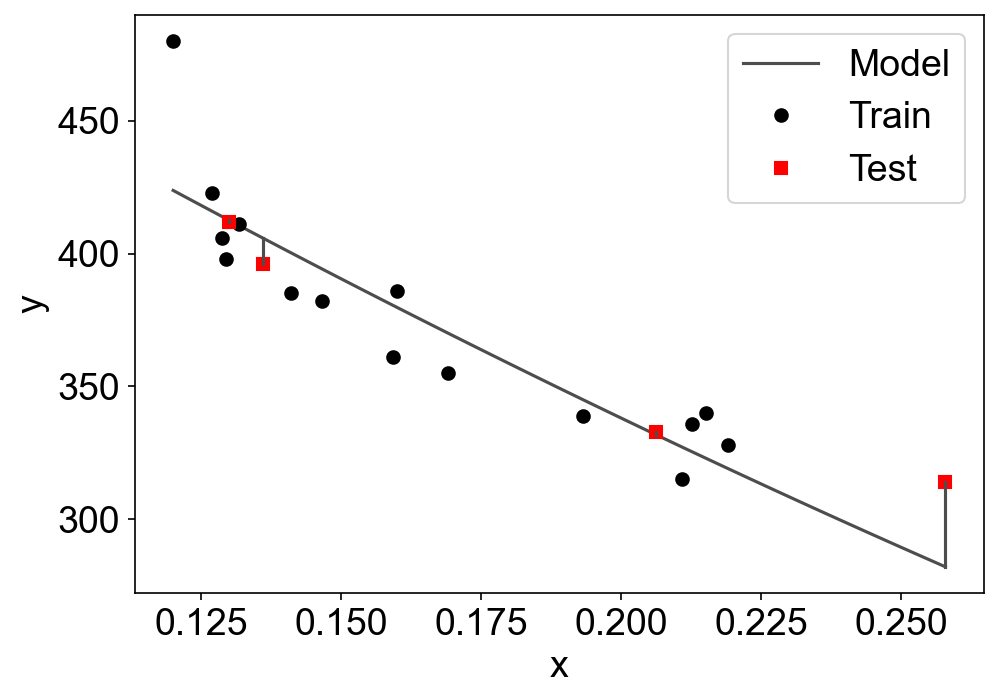

{'model': ElasticNet(),
 'rmse': 26.265345953152337,
 'rmse_std': 11.907030717589803,
 'baseline_rmse': 42.77391131378275,
 'baseline_rmse_std': 11.70132375363213,
 'corr': (-0.8759613287341581, -0.5853544175260804, -0.5329988930538161),
 'corr_std': (0.028097923045357444, 0.08858696175033169, 0.13159885343561117),
 'percent_error': 5.518896038053643,
 'percent_error_std': 2.062647852600025,
 'percent_error_train': 4.43562568460578,
 'percent_error_train_std': 0.4363110635604706,
 'r2_score': 0.025752053688625848,
 'r2_score_std': 1.687636142979799,
 'r2_score_manual': 0.6229418593023393,
 'features': ('var_q_c20_c365_c3_ah',
  'var_q_c20_c56_c3_ah',
  'var_q_c20_c159_c3_ah')}

In [8]:
def train_and_test_model(df, xvars, yvar, 
                         to_plot=1, model=None, num_experiments=None,
                         log=False, square=False, sqrt=False):
    """
    Train and test a univariate linear regression model with cross-validation
    
    Args:
      df is a Pandas DataFrame object
      xvars is a list of strings (the feature names)
      yvar is a string (the label name)
      to_plot : make debug plots if true
      
    Returns:
      a dictionary holding model outputs
    """    
    # Fraction of samples reserved for model testing
    # e.g. 0.2 means 20% of samples reserved. In the 
    # context of cross-validation, this would be 
    # equivalent to a 5-fold cross-validation. The 
    # cross-validation we end up doing is not exactly
    # 5-fold cross-validation since we introduce random
    # sampling and many many repeats
    TEST_SIZE = 0.2
    
    # Number of trials
    num_experiments = num_experiments or 100
    
    # Unpack and filter data
    xvars = [xvars] if isinstance(xvars, str) else xvars
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))
    if square is True:
        df_nonans = df_nonans.apply(lambda x: x**2)
    if sqrt is True:
        df_nonans = df_nonans.apply(lambda x: np.sqrt(abs(x)))
    
    X = df_nonans[xvars].values
    y = df_nonans[yvar].values
        
    percent_error_list = []
    percent_error_train_list = []
    r2_score_list = []
    rmse_list = []
    baseline_rmse_list = []
    intercept_list = []
    coef_list = []
    corr_list = []
    
    has_plotted = 0
    
    for idx in range(num_experiments):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=TEST_SIZE)

        # apply standard scaler (fit only on train, transform both train and test)
        # keep originals for pltos
        X_train_original = X_train
        X_test_original = X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        (model, corr) = build_model(X_train, y_train, model)
        
        y_pred_train = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_mean = np.mean(y_train)
        
        r2_score = model.score(X_test, y_test)
        
        if log is True:
            y_train = np.exp(y_train)
            y_pred_train = np.exp(y_pred_train)
            y_pred = np.exp(y_pred)
            y_test = np.exp(y_test)
            y_train_mean = np.exp(y_train_mean)
        if square is True:
            y_train = np.sqrt(y_train)
            y_pred_train = np.sqrt(y_pred_train)
            y_pred = np.sqrt(y_pred)
            y_test = np.sqrt(y_test)
            y_train_mean = np.sqrt(y_train_mean)
        if sqrt is True:
            y_train = (y_train)**2
            y_pred_train = (y_pred_train)**2
            y_pred = (y_pred)**2
            y_test = (y_test)**2
            y_train_mean = (y_train_mean)**2

        rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))
        percent_error_train = np.mean(np.abs(y_pred_train - y_train)/y_train) * 100
        
        rmse_list.append(rmse)
        percent_error_list.append(percent_error)
        percent_error_train_list.append(percent_error_train)
        r2_score_list.append(r2_score)
        baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
        corr_list.append(corr)
    
        # Give a visual into the cross-validation process
        if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
            has_plotted = 1
            
            x_fit = np.linspace(np.min(X), np.max(X), 100)
            x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
            y_fit = model.predict(x_fit_trans)
            if log is True:
                y_fit = np.exp(y_fit)
            if square is True:
                y_fit = np.sqrt(y_fit)
            if sqrt is True:
                y_fit = y_fit ** 2
            plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
            plt.plot(X_train_original, y_train, 'o', color='k')
            plt.plot(X_test_original, y_test, 's', color='r')
            
            for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
                plt.plot([this_x, this_x], 
                         [this_y, this_ypred], 
                         label='', color=(0.3, 0.3, 0.3))
                
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(['Model', 'Train', 'Test'])
            plt.show()
    
    # Package the output
    final_model = model
    # Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)
        
    final_rmse = np.mean(rmse_list)
    final_rmse_std = np.std(rmse_list)
    
    final_baseline_rmse = np.mean(baseline_rmse_list)
    final_baseline_rmse_std = np.std(baseline_rmse_list)
    
    # Column mean and column std of a list of tuples
    final_corr = tuple(map(np.mean, zip(*corr_list)))
    final_corr_std = tuple(map(np.std, zip(*corr_list)))
    
    final_percent_error = np.mean(percent_error_list)
    final_percent_error_std = np.std(percent_error_list)
    final_percent_error_train = np.mean(percent_error_train_list)
    final_percent_error_train_std = np.std(percent_error_train_list)
    
#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
    final_r2_score = np.mean(r2_score_list)
    final_r2_score_std = np.std(r2_score_list)
    
    model_output_dict = dict()
    model_output_dict['model'] = final_model
    model_output_dict['rmse'] = final_rmse
    model_output_dict['rmse_std'] = final_rmse_std
    model_output_dict['baseline_rmse'] = final_baseline_rmse
    model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
    model_output_dict['corr'] = final_corr
    model_output_dict['corr_std'] = final_corr_std
    model_output_dict['percent_error'] = final_percent_error
    model_output_dict['percent_error_std'] = final_percent_error_std
    model_output_dict['percent_error_train'] = final_percent_error_train
    model_output_dict['percent_error_train_std'] = final_percent_error_train_std
    model_output_dict['r2_score'] = final_r2_score
    model_output_dict['r2_score_std'] = final_r2_score_std
    model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
    model_output_dict['features'] = tuple(xvars)
    
    return model_output_dict

# Test
# one feature
# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      log=True)

# train_and_test_model(df, 
#                      "var_q_c20_c365_c3_ah", 
#                      'cycles_to_80_pct', 
#                      to_plot=1,
#                      square=True)

train_and_test_model(df, 
                     "var_q_c20_c365_c3_ah", 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     sqrt=True)

# multiple features
train_and_test_model(df, 
                     ["var_q_c20_c365_c3_ah", "var_q_c20_c56_c3_ah", "var_q_c20_c159_c3_ah"], 
                     'cycles_to_80_pct', 
                     to_plot=1,
                     model=ElasticNet())

# Single feature

## Set up and fit/predict/score

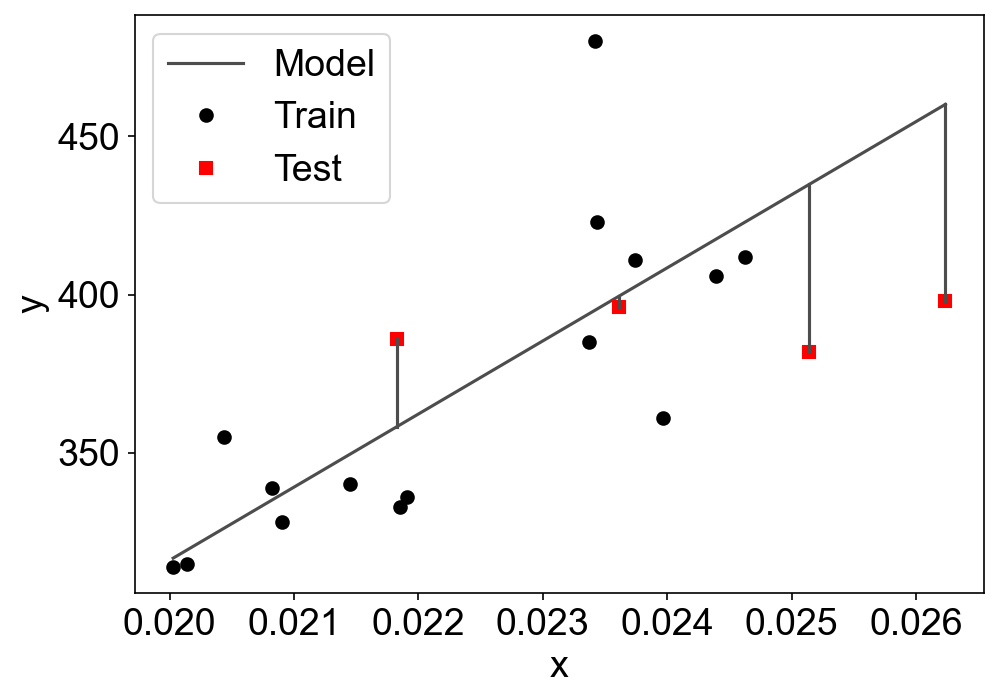

In [9]:
# Set the y-variable (the output the model is trying to predict)
yvar80 = 'cycles_to_80_pct'
yvar70 = 'cycles_to_70_pct'
yvar60 = 'cycles_to_60_pct'
yvar50 = 'cycles_to_50_pct'
yvar = yvar80

# Gather a list of modeled results. 
# Each element of the list holds all modeled results for a particular cycle
results_list = []

# First take care of the formation delta V signal, which only exists for the initial cycle
xvar = 'form_6hr_rest_delta_voltage_v'

model_output_dict = train_and_test_model(df, xvar, yvar)
model = model_output_dict['model']

results_dict = dict()
results_dict['cycle_index'] = 0 #
results_dict[xvar] = model_output_dict

results_list.append(results_dict)

Working on cycle 3...


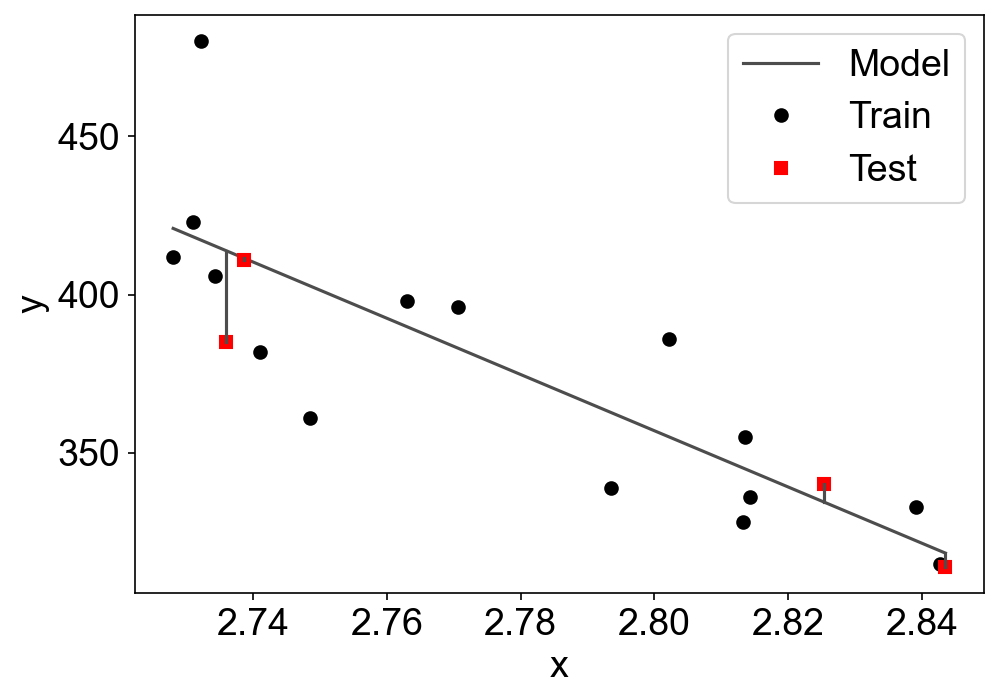

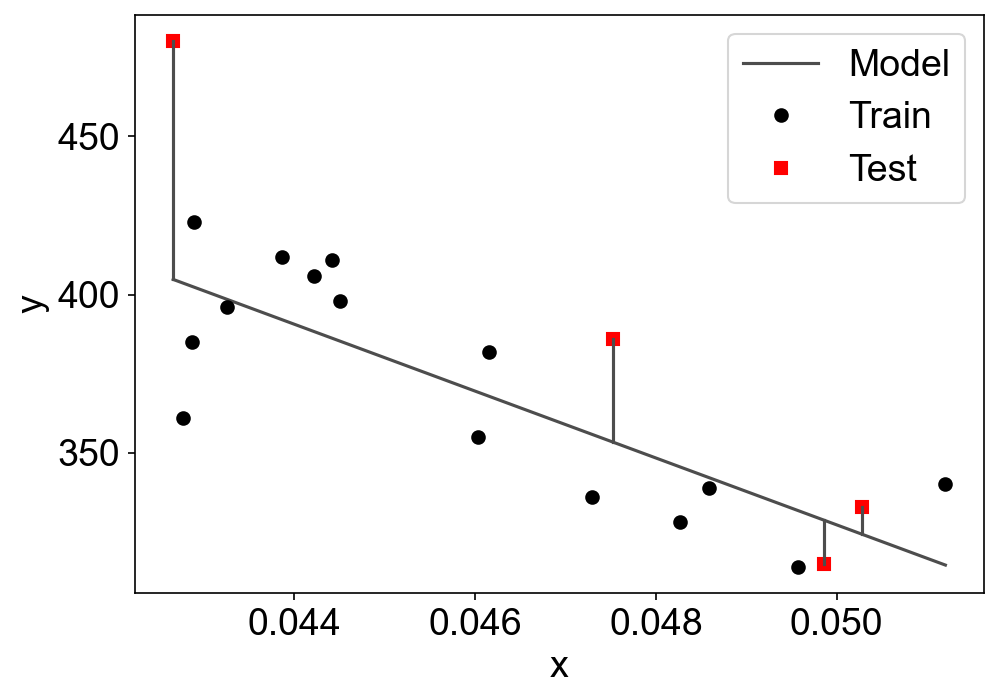

Working on cycle 56...


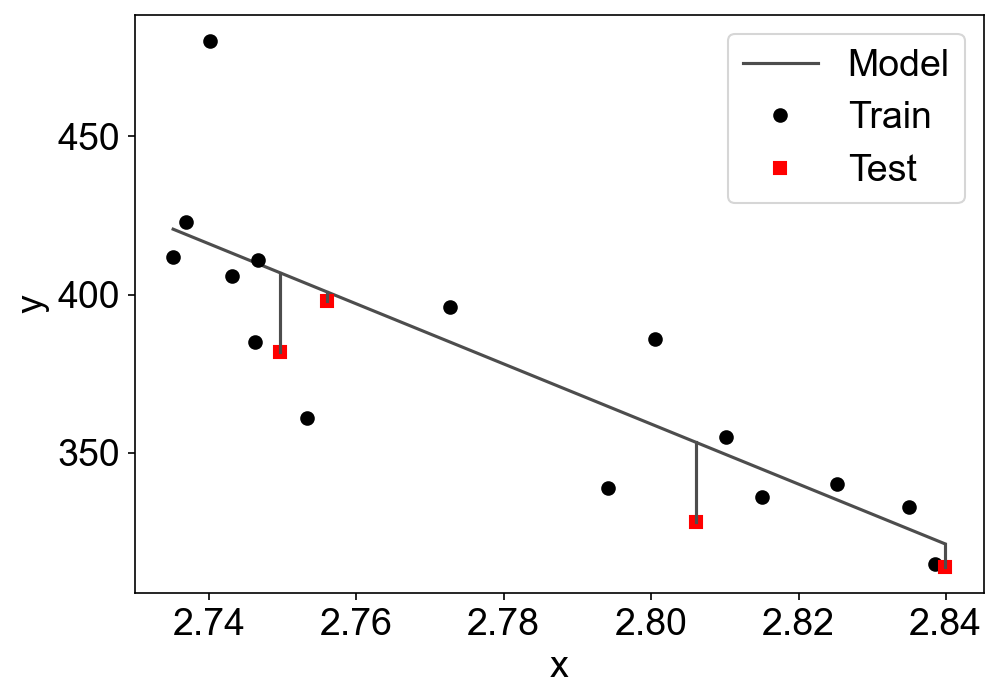

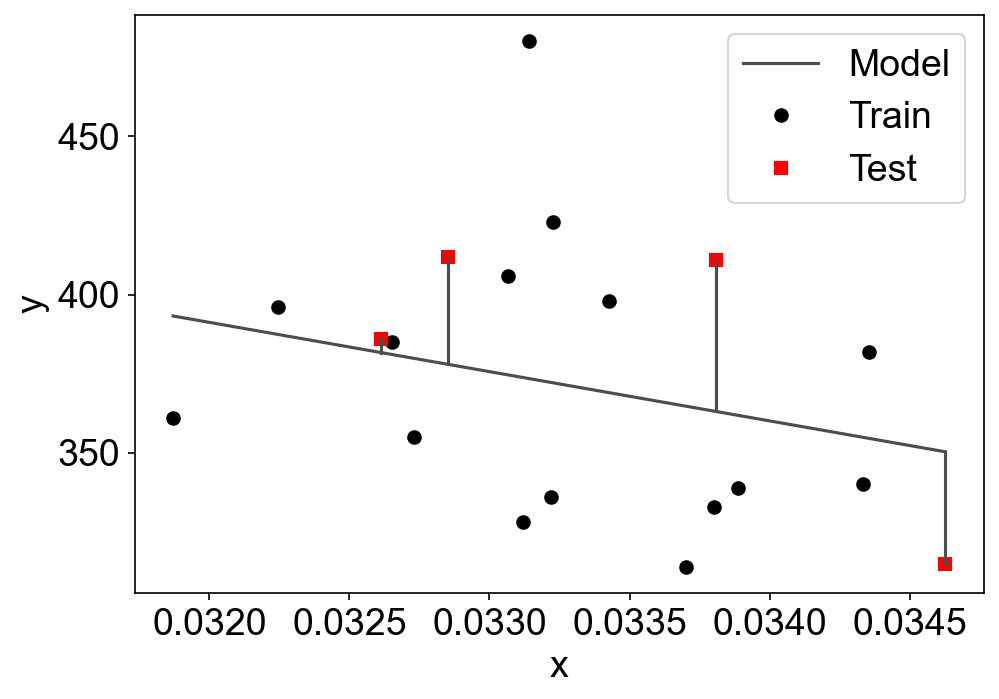

Working on cycle 159...


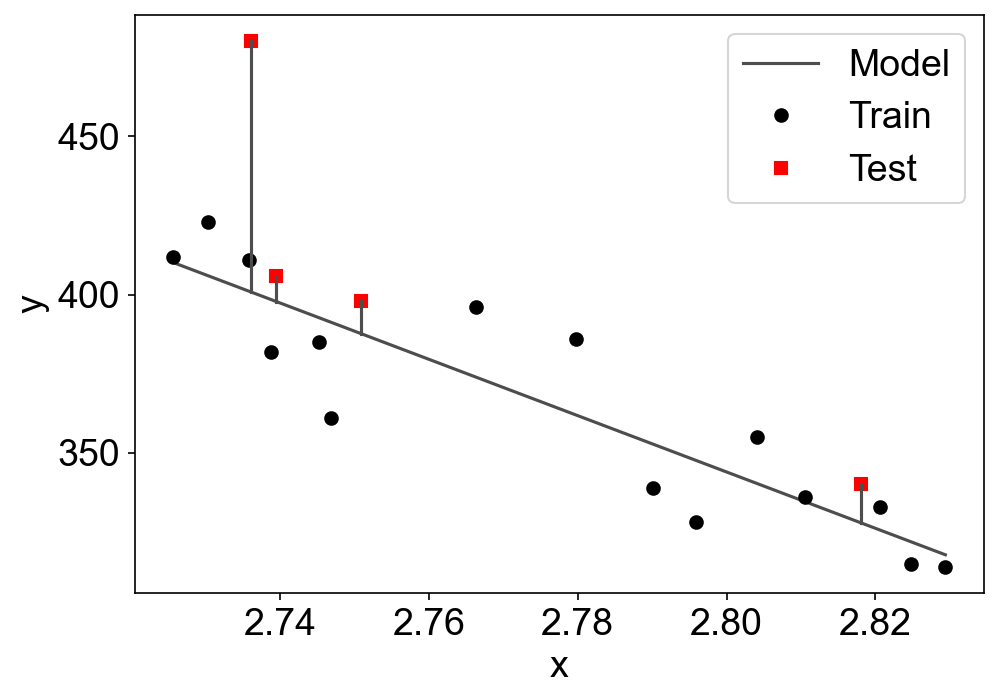

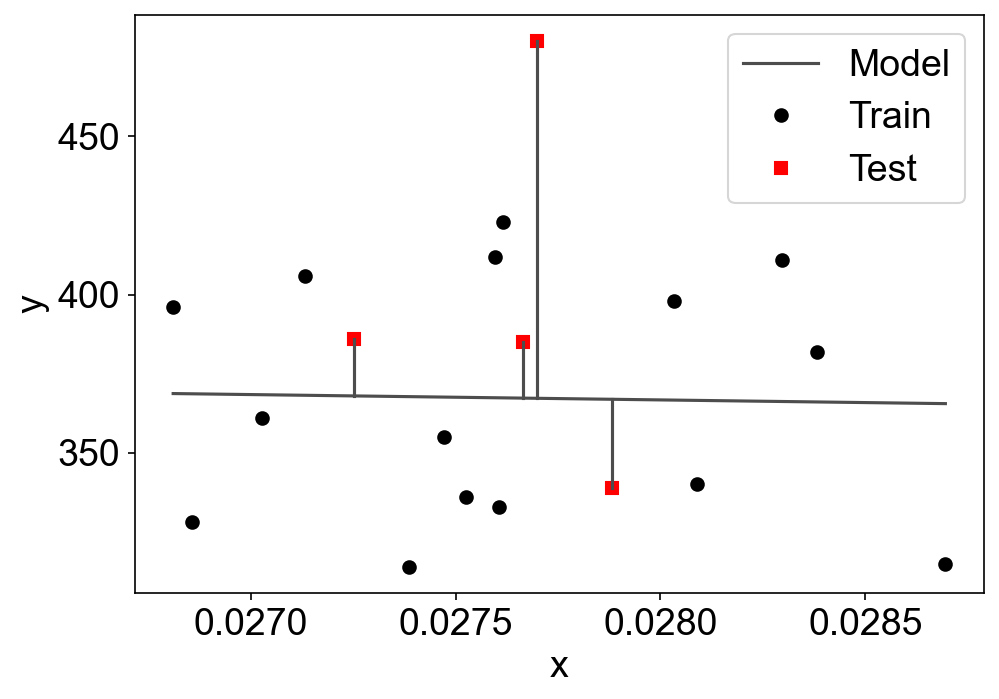

Working on cycle 262...


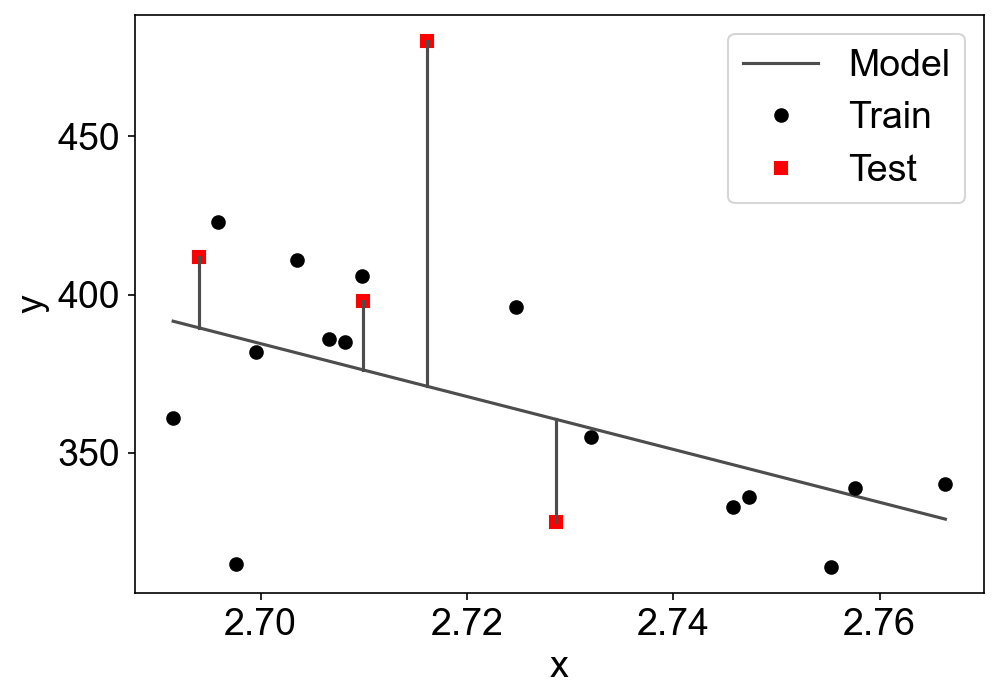

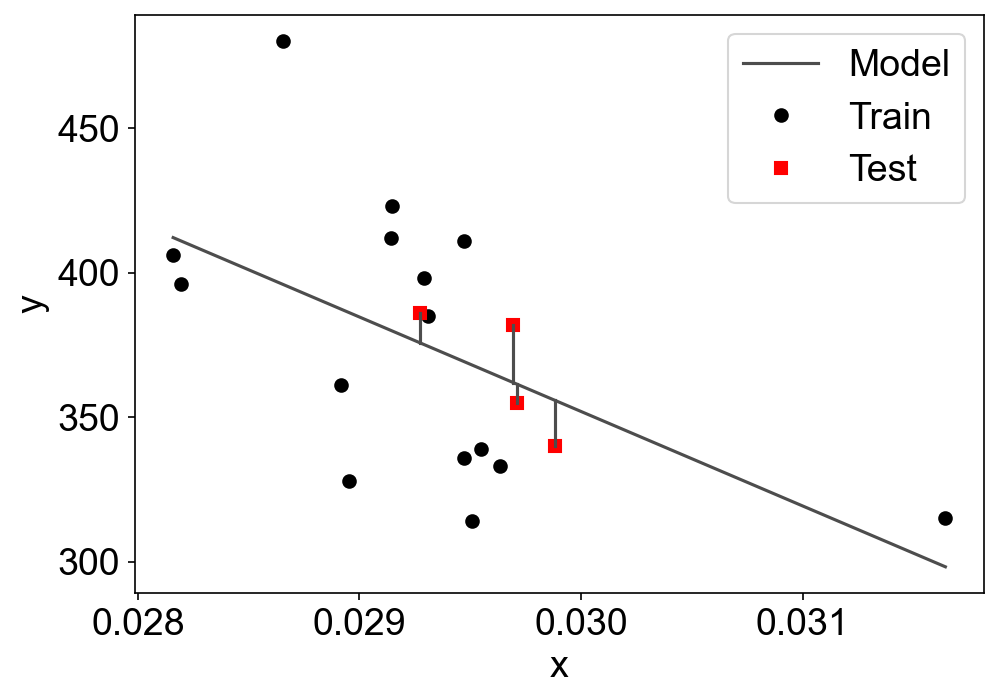

Working on cycle 365...


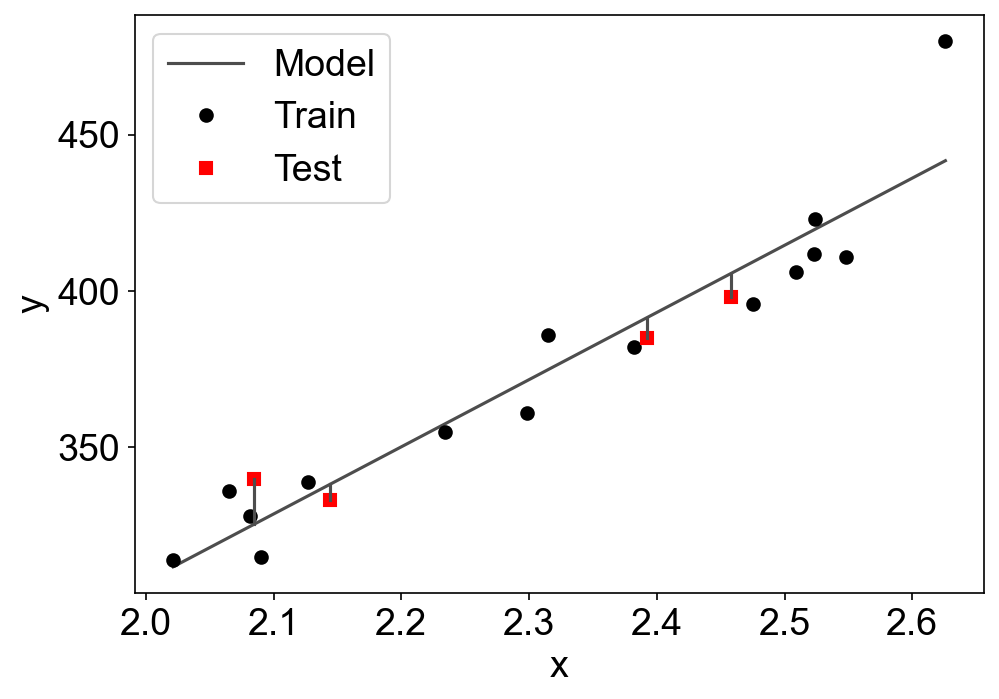

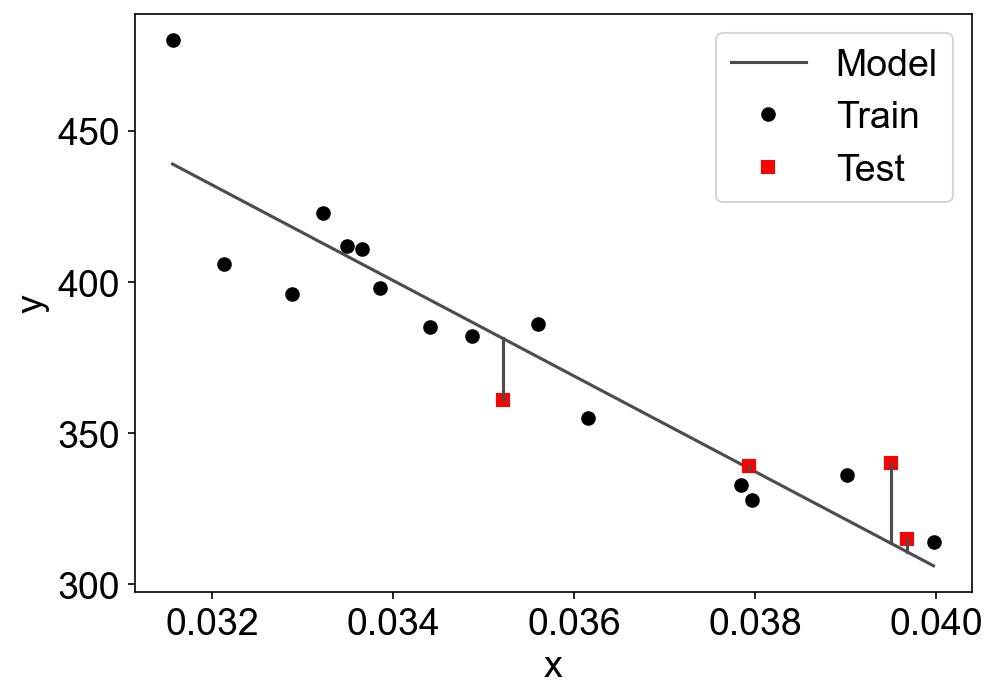

Done.


In [10]:
# Now take care of the rest of the signals. These signals exist for multiple cycles since 
# they exist at each RPT. So we will loop through the valid cycle indices and repeat this 
# process.

cycle_target_list = [3, 56, 159, 262, 365]

for cycle_idx in cycle_target_list:
    
    print(f'Working on cycle {cycle_idx}...')
    
    # Assemble x variables of interest
    xvar_array = [f'esoh_c{cycle_idx}_Cn',
                  f'dcr_10s_5_soc_at_c{cycle_idx}',
                  f'var_q_c{cycle_idx}_c3']
    
    results_dict = dict()
    results_dict['cycle_index'] = cycle_idx
    
    # Loop over x-variables
    for xvar in xvar_array:

        if not xvar in df.columns:
            continue
        
        model_output_dict = train_and_test_model(df, xvar, yvar)
        
        model = model_output_dict['model']

        if '_Cn' in xvar:
            xvar_label = 'Cn'
        if 'dcr_10s_5_soc' in xvar:
            xvar_label = 'dcr_10s_5_soc'
        if 'var_q' in xvar:
            xvar_label = 'var_q'
    
        results_dict[xvar_label] = model_output_dict
        
    results_list.append(results_dict)      
    
print('Done.')
    

Take a look at the results list variable.

It is a list of dictionaries. Each dictionary holds the output for a single cycle index.

In [11]:
results_list

[{'cycle_index': 0,
  'form_6hr_rest_delta_voltage_v': {'model': LinearRegression(),
   'rmse': 30.169282800892546,
   'rmse_std': 13.362535434376658,
   'baseline_rmse': 42.5541180857022,
   'baseline_rmse_std': 13.451940403331403,
   'corr': (0.69943056540625,),
   'corr_std': (0.06317210501453371,),
   'percent_error': 6.424319487560849,
   'percent_error_std': 2.214689609908985,
   'percent_error_train': 5.8537996411324515,
   'percent_error_train_std': 0.5666273075803502,
   'r2_score': -0.7253070353238015,
   'r2_score_std': 4.428557235864721,
   'r2_score_manual': 0.4973718784553429,
   'features': ('form_6hr_rest_delta_voltage_v',)}},
 {'cycle_index': 3,
  'Cn': {'model': LinearRegression(),
   'rmse': 22.020089559488174,
   'rmse_std': 10.660304461278699,
   'baseline_rmse': 42.91172932486922,
   'baseline_rmse_std': 13.707464621481213,
   'corr': (-0.844311206296245,),
   'corr_std': (0.032054789535210675,),
   'percent_error': 4.611411161617266,
   'percent_error_std': 1.708

## Re-package the data to become easily plottable

Repackage the data to index by feature, which makes it easier for plotting.

There is probably a more "pandas-y" way to do this.

In [12]:
# Get a list of unique x-variable labels
unique_keys = set()
for result_dict in results_list:
    for key in result_dict.keys():
        unique_keys.add(key)
unique_keys.remove('cycle_index')

# Assemble the outputs into a dictionary
output_dict = dict()
for key in unique_keys:
    
    cycle_list = []
    rmse_list = []
    rmse_std_list = []
    corr_list = []
    corr_std_list = []
    percent_error_list = []
    percent_error_std_list = []
    
    for result_dict in results_list:

        cycle_list.append(result_dict['cycle_index'])    
        
        if not key in result_dict:
            rmse_list.append(np.nan)
            rmse_std_list.append(np.nan)
            corr_list.append(np.nan)
            corr_std_list.append(np.nan)
            percent_error_list.append(np.nan)
            percent_error_std_list.append(np.nan)
            continue

        rmse_list.append(result_dict[key]['rmse'])
        rmse_std_list.append(result_dict[key]['rmse_std'])
        if len(result_dict[key]['corr']) == 1:
            corr_list.append(result_dict[key]['corr'][0])
            corr_std_list.append(result_dict[key]['corr_std'][0])
        percent_error_list.append(result_dict[key]['percent_error'])
        percent_error_std_list.append(result_dict[key]['percent_error_std'])
        
        
    this_result = dict()
    this_result['cycle_index'] = cycle_list
    this_result['rmse'] = rmse_list
    this_result['rmse_std'] = rmse_std_list
    this_result['corr'] = corr_list
    this_result['corr_std'] = corr_std_list
    this_result['percent_error'] = percent_error_list
    this_result['percent_error_std'] = percent_error_std_list
    
    output_dict[key] = this_result
    
# The output dictionary is now indexed by feature
output_dict

{'form_6hr_rest_delta_voltage_v': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [30.169282800892546, nan, nan, nan, nan, nan],
  'rmse_std': [13.362535434376658, nan, nan, nan, nan, nan],
  'corr': [0.69943056540625, nan, nan, nan, nan, nan],
  'corr_std': [0.06317210501453371, nan, nan, nan, nan, nan],
  'percent_error': [6.424319487560849, nan, nan, nan, nan, nan],
  'percent_error_std': [2.214689609908985, nan, nan, nan, nan, nan]},
 'dcr_10s_5_soc': {'cycle_index': [0, 3, 56, 159, 262, 365],
  'rmse': [nan,
   27.460993167763625,
   42.39998802429084,
   44.648787903750645,
   38.31211625207173,
   17.927046152561427],
  'rmse_std': [nan,
   11.05634156829595,
   13.591407235471566,
   13.080332001722894,
   13.239602600006169,
   7.618485840456825],
  'corr': [nan,
   -0.8013667513492158,
   -0.33885615391915,
   -0.05617633151310282,
   -0.565035630183389,
   -0.9322620715866019],
  'corr_std': [nan,
   0.03630410480748523,
   0.08973635002641185,
   0.10380033135309345,
 

## Visualize the results

In [13]:
# Create another dictionary of labels
label_dict = dict()
label_dict['var_q'] = '$\Delta Q$'
label_dict['Cn'] = '$C_n$'
label_dict['dcr_10s_5_soc'] = '$R_{10s, 5\%SOC}$'
label_dict['form_6hr_rest_delta_voltage_v'] = '$\Delta V_{rest, 6hr}$'

<Figure size 1050x750 with 0 Axes>

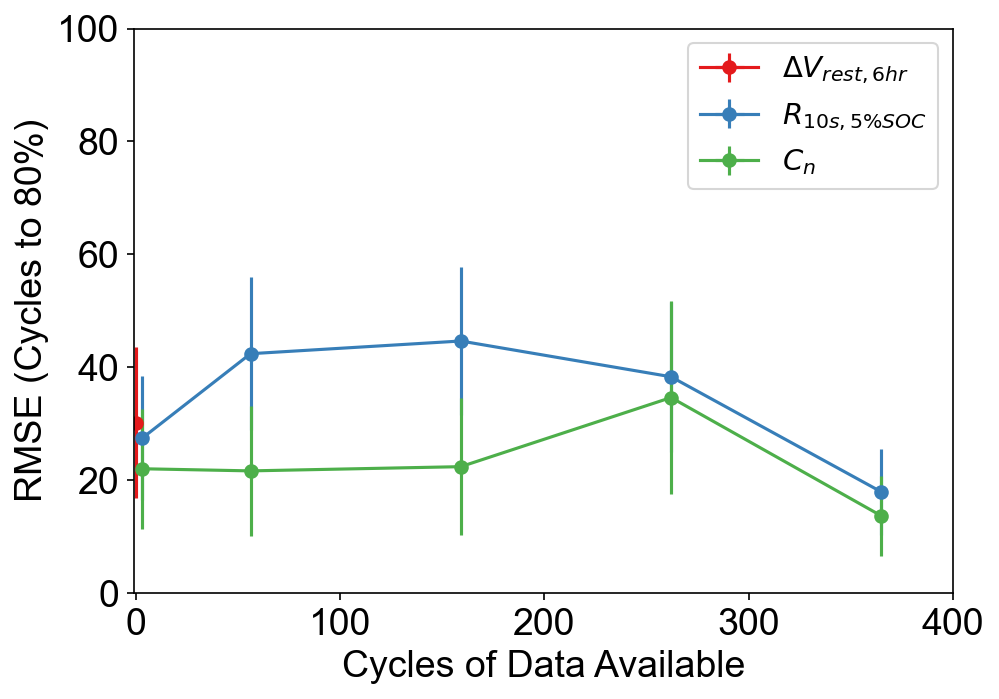

<Figure size 1050x750 with 0 Axes>

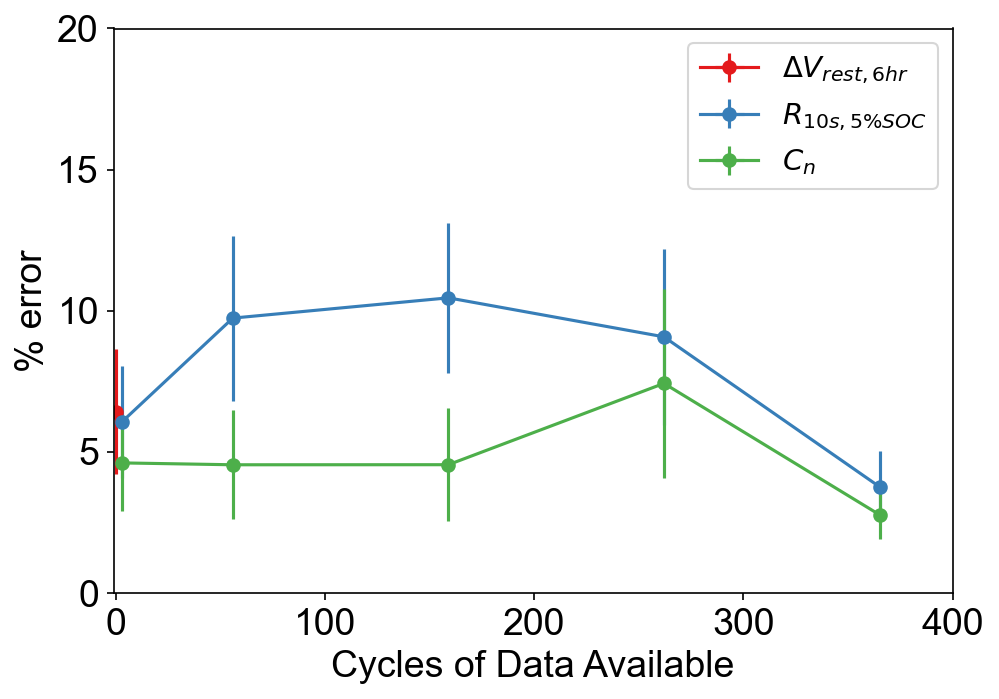

<Figure size 1050x750 with 0 Axes>

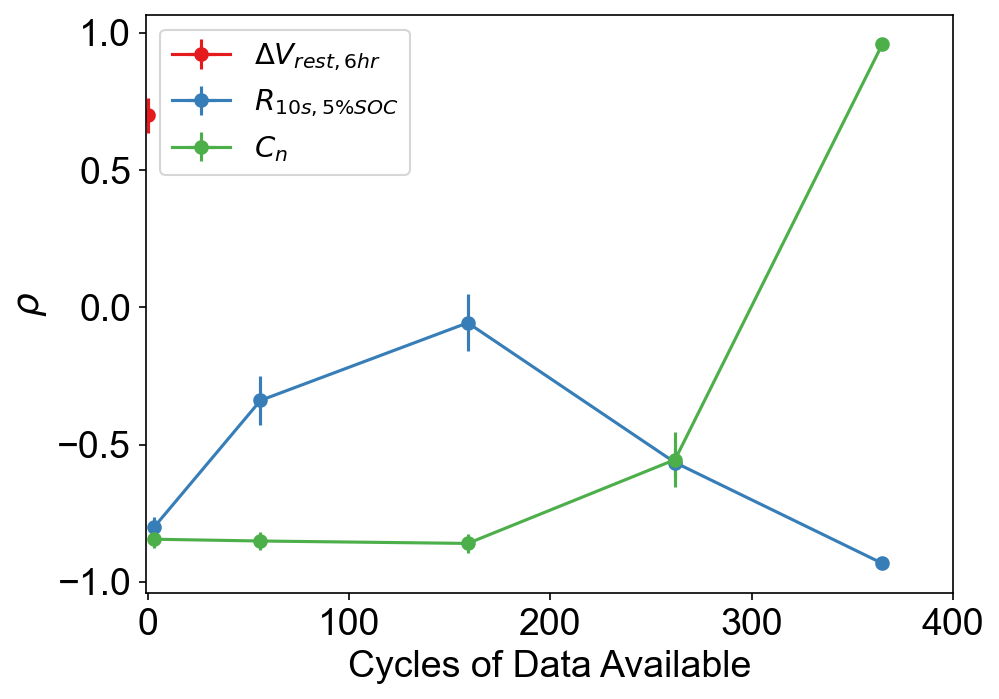

In [14]:
# Unpack and plot the dictionary of outputs
plt.figure()
fig, ax = plt.subplots()

labels = ["c%.0f" % number for number in output_dict[list(output_dict.keys())[0]]['cycle_index']]
labels[0] = "         Form."
    
# RMSE error (cycles to 70%)
for idx, key in enumerate(output_dict):

    x = output_dict[key]['cycle_index']
    y = output_dict[key]['rmse']
    error = output_dict[key]['rmse_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('RMSE (Cycles to 80%)')
plt.xlim((-1, 400))
plt.ylim((0, 100))
plt.legend(fontsize=14)

# Percent error
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['percent_error']
    error = output_dict[key]['percent_error_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel('% error')
plt.ylim((0, 20))
plt.xlim((-1, 400))
plt.legend(fontsize=14)


# Correlation coefficient evolution
plt.figure()
fig, ax = plt.subplots()

for idx, key in enumerate(output_dict):
    
    x = output_dict[key]['cycle_index']
    y = output_dict[key]['corr']
    error = output_dict[key]['corr_std']
    
    ax.errorbar(x, y, xerr=0, yerr=error, fmt='-o', 
                label=label_dict[key], color=cmap(idx))

plt.xlabel('Cycles of Data Available')
plt.ylabel(r'$\rho$')
plt.xlim((-1, 400))
plt.legend(fontsize=14)

# Multiple features from formation

## Data analysis

In [15]:
yvar = yvar70

Select relevant formation features

In [16]:
form_select = lambda x: x.startswith("form_") and "trace" not in x and "rebound" not in x
form_features = list(filter(form_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_form = df[form_features + labels]
df_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 33 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah  19 non-null     float64
 1   form_last_charge_voltage_after_1s            19 non-null     float64
 2   form_last_charge_voltage_after_10s           19 non-null     float64
 3   form_last_charge_voltage_after_60s           19 non-null     float64
 4   form_first_charge_capacity_ah                19 non-null     float64
 5   form_first_discharge_capacity_ah             19 non-null     float64
 6   form_first_cycle_efficiency                  19 non-null     float64
 7   form_final_discharge_capacity_ah             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr      19 non-null     float64
 9   form_6hr_rest_delta_voltage_v_0_to_2_hr      19 non-null     float64
 10  form

In [17]:
df_form_sq = df_form.apply(lambda x: x**2).rename(lambda s: s + "_squared", axis="columns")
df_form_sq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 33 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   form_first_discharge_capacity_below_3p2v_ah_squared  19 non-null     float64
 1   form_last_charge_voltage_after_1s_squared            19 non-null     float64
 2   form_last_charge_voltage_after_10s_squared           19 non-null     float64
 3   form_last_charge_voltage_after_60s_squared           19 non-null     float64
 4   form_first_charge_capacity_ah_squared                19 non-null     float64
 5   form_first_discharge_capacity_ah_squared             19 non-null     float64
 6   form_first_cycle_efficiency_squared                  19 non-null     float64
 7   form_final_discharge_capacity_ah_squared             19 non-null     float64
 8   form_6hr_rest_delta_voltage_v_0_to_1_hr_squared      19 non-null     flo

In [18]:
df_form_plus_sq = pd.concat([df_form, df_form_sq], axis=1)
df_form_plus_sq.head()

form_first_discharge_capacity_below_3p2v_ah  \
0                                     0.077820   
1                                     0.073791   
2                                     0.074725   
3                                     0.069433   
4                                     0.073127   

   form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
0                           3.393505                            3.403936   
1                           3.401924                            3.412256   
2                           3.398755                            3.409052   
3                           3.400189                            3.410498   
4                           3.396888                            3.407243   

   form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
0                            3.420587                       2.755302   
1                            3.428007                       2.698299   
2                            3.424840                       2.713403   
3                            3.426320                       2.696613   
4                            3.423244                       2.713639   

   form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
0                          2.312734                     0.839376   
1                          2.313851                     0.857522   
2                          2.309945                     0.851309   
3                          2.310417                     0.856785   
4                          2.330587                     0.858842   

   form_final_discharge_capacity_ah  form_6hr_rest_delta_voltage_v_0_to_1_hr  \
0                          2.367225                                 0.011104   
1                          2.363418                                 0.010694   
2                          2.362668                                 0.011531   
3                          2.356018                                 0.010730   
4                          2.381257                                 0.011573   

   form_6hr_rest_delta_voltage_v_0_to_2_hr  \
0                                 0.014412   
1                                 0.013741   
2                                 0.015044   
3                                 0.013928   
4                                 0.015010   

   form_6hr_rest_delta_voltage_v_0_to_3_hr  \
0                                 0.016395   
1                                 0.015612   
2                                 0.017074   
3                                 0.015780   
4                                 0.017089   

   form_6hr_rest_delta_voltage_v_0_to_4_hr  \
0                                 0.017794   
1                                 0.017002   
2                                 0.018645   
3                                 0.017201   
4                                 0.018494   

   form_6hr_rest_delta_voltage_v_0_to_5_hr  \
0                                 0.018984   
1                                 0.018085   
2                                 0.019790   
3                                 0.018138   
4                                 0.019764   

   form_6hr_rest_delta_voltage_v_0_to_6_hr  \
0                                 0.019909   
1                                 0.018962   
2                                 0.020716   
3                                 0.019097   
4                                 0.020793   

   form_6hr_rest_delta_voltage_v_1_to_6_hr  \
0                                 0.008731   
1                                 0.008188   
2                                 0.009108   
3                                 0.008275   
4                                 0.009128   

   form_6hr_rest_delta_voltage_v_2_to_6_hr  \
0                                 0.005468   
1                                 0.005158   
2                                 0.005626   
3                                 0.005127   
4                             

Look for correlations

In [19]:
df_form.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct                               1.000000
cycles_to_60_pct                               0.995579
cycles_to_70_pct                               0.976940
cycles_to_80_pct                               0.971337
form_last_charge_voltage_after_60s             0.802370
form_c20_charge_right_peak_v_per_ah            0.772470
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.730636
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.729484
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.726760
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.721277
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.711559
form_6hr_rest_delta_voltage_v                  0.710422
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.698247
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.651170
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.565207
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.505149
form_6hr_rest_delta_voltage_v_4_to_6_hr        0.467371
form_6hr_rest_delta_voltage_v_5_to_6_hr        0

Select and plot features with abs(corr) > 0.6

In [20]:
high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.6
high_corr_form_features = list(filter(high_corr, form_features))
high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_10s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_6hr_rest_delta_voltage_v_0_to_1_hr',
 'form_6hr_rest_delta_voltage_v_0_to_2_hr',
 'form_6hr_rest_delta_voltage_v_0_to_3_hr',
 'form_6hr_rest_delta_voltage_v_0_to_4_hr',
 'form_6hr_rest_delta_voltage_v_0_to_5_hr',
 'form_6hr_rest_delta_voltage_v_0_to_6_hr',
 'form_6hr_rest_delta_voltage_v_1_to_6_hr',
 'form_c20_charge_right_peak_v_per_ah',
 'form_6hr_rest_delta_voltage_v',
 'form_6hr_rest_voltage_v',
 'form_6hr_rest_mv_per_sec_initial']

In [21]:
very_high_corr = lambda name: abs(df_form.corr()[yvar][name]) > 0.77
very_high_corr_form_features = list(filter(very_high_corr, form_features))
very_high_corr_form_features

['form_first_discharge_capacity_below_3p2v_ah',
 'form_last_charge_voltage_after_1s',
 'form_last_charge_voltage_after_60s',
 'form_first_discharge_capacity_ah',
 'form_first_cycle_efficiency',
 'form_c20_charge_right_peak_v_per_ah']

In [22]:
df_form[high_corr_form_features].corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
form_6hr_rest_mv_per_sec_initial               0.871221
form_6hr_rest_voltage_v                        0.890137
form_last_charge_voltage_after_10s             0.937693
form_first_discharge_capacity_below_3p2v_ah    0.994841
form_last_charge_voltage_after_1s              0.998766
form_first_cycle_efficiency                    0.999884
form_first_discharge_capacity_ah               1.000000
Name: form_first_discharge_capacity_ah, dtype: f

<ipython-input-23-d77f4693741f>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-23-d77f4693741f>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
<ipython-input-23-d77f4693741f>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")
/Users/aweng/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


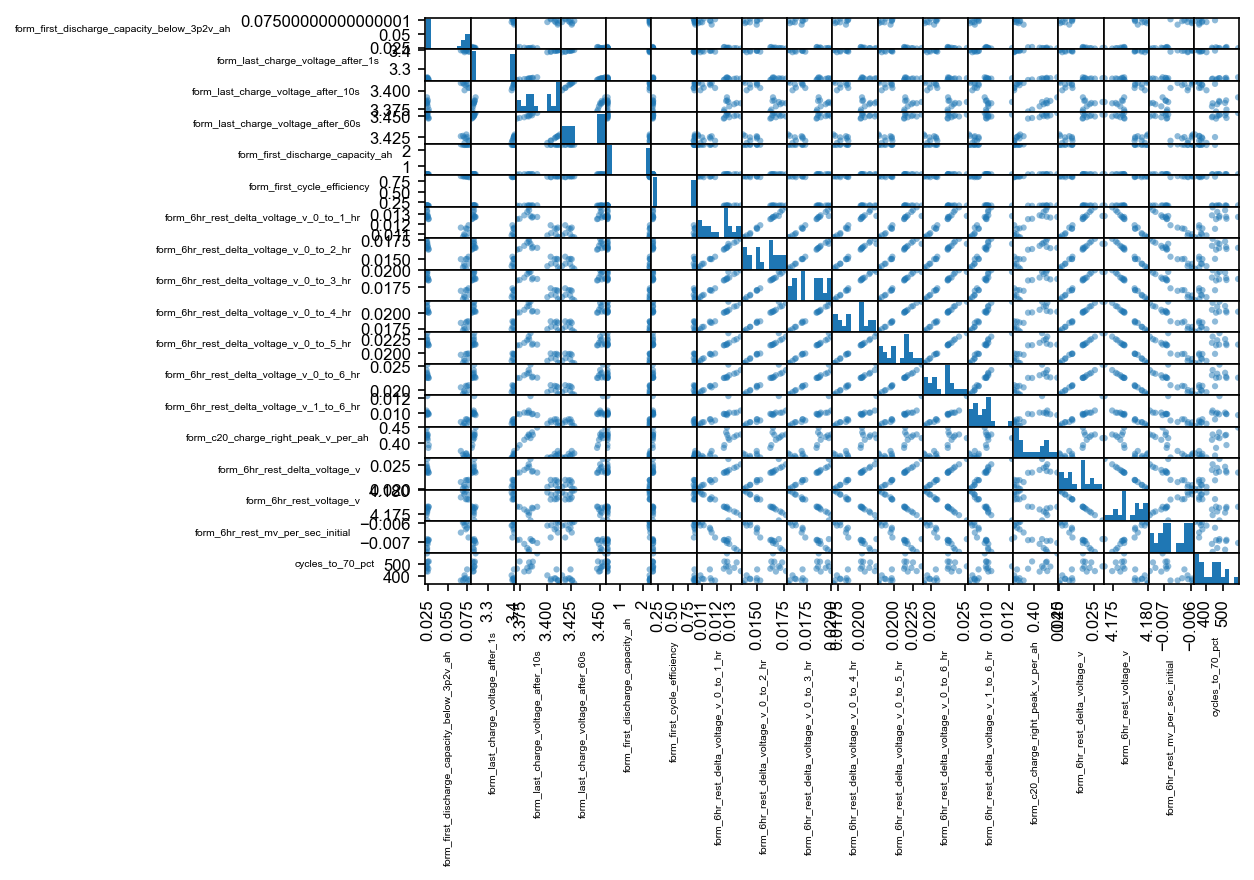

In [23]:
from pandas.plotting import scatter_matrix
plt.rcParams['axes.labelsize'] = 5
axes = scatter_matrix(df_form[high_corr_form_features + [yvar]])

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
OUTPUT_DIR = "code-base/imgs/"
plt.tight_layout()
plt.savefig(OUTPUT_DIR + "form_scatter_matrix.pdf")

In [24]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
config_plots()

### with log

In [25]:
df_form_log = df_form.apply(lambda x: np.log(abs(x)))
df_form_log.describe()

form_first_discharge_capacity_below_3p2v_ah  \
count                                    19.000000   
mean                                     -3.198979   
std                                       0.564067   
min                                      -3.766923   
25%                                      -3.729466   
50%                                      -3.649625   
75%                                      -2.626924   
max                                      -2.553354   

       form_last_charge_voltage_after_1s  form_last_charge_voltage_after_10s  \
count                          19.000000                           19.000000   
mean                            1.198703                            1.222002   
std                             0.023588                            0.004068   
min                             1.174555                            1.215440   
25%                             1.177094                            1.218782   
50%                             1.179177                            1.221083   
75%                             1.223027                            1.226052   
max                             1.224341                            1.227374   

       form_last_charge_voltage_after_60s  form_first_charge_capacity_ah  \
count                           19.000000                      19.000000   
mean                             1.234841                       1.003142   
std                              0.004154                       0.012057   
min                              1.228971                       0.988929   
25%                              1.231004                       0.994866   
50%                              1.237599                       0.998291   
75%                              1.238623                       1.009378   
max                              1.239590                       1.037936   

       form_first_discharge_capacity_ah  form_first_cycle_efficiency  \
count                         19.000000                    19.000000   
mean                           0.008368                    -0.994774   
std                            0.812216                     0.816364   
min                           -0.759595                    -1.784166   
25%                           -0.741329                    -1.746586   
50%                           -0.728661                    -1.722820   
75%                            0.838672                    -0.157774   
max                            0.850454                    -0.140043   

       form_final_discharge_capacity_ah  \
count                         19.000000   
mean                           0.860630   
std                            0.004333   
min                            0.854034   
25%                            0.858194   
50%                            0.860109   
75%                            0.862090   
max                            0.869140   

       form_6hr_rest_delta_voltage_v_0_to_1_hr  \
count                                19.000000   
mean                                 -4.416723   
std                                   0.078911   
min                                  -4.538118   
25%                                  -4.481583   
50%                                  -4.382669   
75%                                  -4.360943   
max                                  -4.293166   

       form_6hr_rest_delta_voltage_v_0_to_2_hr  \
count                                19.000000   
mean                                 -4.154705   
std                                   0.081232   
min                                  -4.287379   
25%                                  -4.219624   
50%                                  -4.119745   
75%                                  -4.093166   
max                                  -4.035049   

       form_6hr_rest_delta_voltage_v_0_to_3_hr  \
count                                19.000000   
mean                                 -4.027465   
std                      

In [26]:
df_form_log.corr()[yvar].sort_values(ascending=False)

cycles_to_70_pct                               1.000000
cycles_to_60_pct                               0.983852
cycles_to_80_pct                               0.978925
cycles_to_50_pct                               0.973508
form_last_charge_voltage_after_60s             0.834031
form_c20_charge_right_peak_v_per_ah            0.808079
form_6hr_rest_delta_voltage_v_0_to_3_hr        0.775806
form_6hr_rest_delta_voltage_v_0_to_4_hr        0.770741
form_6hr_rest_delta_voltage_v_0_to_2_hr        0.770716
form_6hr_rest_delta_voltage_v_0_to_5_hr        0.764190
form_6hr_rest_delta_voltage_v_0_to_1_hr        0.751677
form_6hr_rest_delta_voltage_v_0_to_6_hr        0.749858
form_6hr_rest_delta_voltage_v                  0.747567
form_6hr_rest_mv_per_sec_initial               0.707107
form_6hr_rest_delta_voltage_v_1_to_6_hr        0.689184
form_6hr_rest_delta_voltage_v_2_to_6_hr        0.604837
form_6hr_rest_delta_voltage_v_3_to_6_hr        0.541764
form_6hr_rest_delta_voltage_v_4_to_6_hr        0

## Training a regularized model

### Individual features

In [27]:
from sklearn.dummy import DummyRegressor

In [28]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
# train_and_test_model(df, form_features, yvar, to_plot=0, model=Ridge())
# model = ElasticNet(0.01, l1_ratio=0.5)
# train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
# print(model.coef_)

form_first_discharge_capacity_below_3p2v_ah       7.71 (2.48 std)
form_last_charge_voltage_after_1s                 7.41 (2.41 std)
form_last_charge_voltage_after_10s                8.83 (2.75 std)
form_last_charge_voltage_after_60s                7.80 (2.71 std)
form_first_charge_capacity_ah                     14.40 (3.99 std)
form_first_discharge_capacity_ah                  7.43 (2.40 std)
form_first_cycle_efficiency                       7.53 (2.56 std)
form_final_discharge_capacity_ah                  13.10 (4.41 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           9.03 (3.34 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.66 (3.04 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.89 (2.90 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           9.04 (2.75 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           8.92 (2.70 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.50 (2.82 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           11.18 (3.78 std)
form_6h

with log

In [29]:
for f in form_features:
    out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000, log=True)
    print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000, log=True)
print(f"{'Dummy regressor (predict mean)':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")


form_first_discharge_capacity_below_3p2v_ah       7.60 (2.53 std)
form_last_charge_voltage_after_1s                 7.32 (2.59 std)
form_last_charge_voltage_after_10s                8.32 (2.97 std)
form_last_charge_voltage_after_60s                7.37 (2.59 std)
form_first_charge_capacity_ah                     14.03 (3.84 std)
form_first_discharge_capacity_ah                  7.34 (2.50 std)
form_first_cycle_efficiency                       7.32 (2.41 std)
form_final_discharge_capacity_ah                  12.96 (4.15 std)
form_6hr_rest_delta_voltage_v_0_to_1_hr           8.98 (3.29 std)
form_6hr_rest_delta_voltage_v_0_to_2_hr           8.67 (3.06 std)
form_6hr_rest_delta_voltage_v_0_to_3_hr           8.51 (2.90 std)
form_6hr_rest_delta_voltage_v_0_to_4_hr           8.66 (2.70 std)
form_6hr_rest_delta_voltage_v_0_to_5_hr           8.99 (2.74 std)
form_6hr_rest_delta_voltage_v_0_to_6_hr           9.41 (2.84 std)
form_6hr_rest_delta_voltage_v_1_to_6_hr           11.16 (4.40 std)
form_6h

### Manual hyperparameter loops

In [30]:
def manual_gridsearch(features, yvar, log=False):
    gridsearch = {}
    def ridge(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Ridge(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Ridge"] = (alphas, list(map(ridge, alphas)))
    
    def lasso(alpha):
        return train_and_test_model(df, features, yvar, to_plot=0, model=Lasso(alpha), log=log)["percent_error"]

    alphas = np.logspace(0,2,20)
    gridsearch["Lasso"] = (alphas, list(map(lasso, alphas)))
    
    def elastic_net(alpha, l1_ratio):
        return train_and_test_model(df, features, yvar, to_plot=0, 
                                    model=ElasticNet(alpha, l1_ratio=l1_ratio), log=log)["percent_error"]

    N = 10
    alphas = np.logspace(0,2,N)
    l1_ratios = np.linspace(0,1,N)
    errors = np.empty((N,N))
    for i, alpha in enumerate(alphas):
        print(i)
        for j, l1_ratio in enumerate(l1_ratios):
            errors[i,j] = elastic_net(alpha, l1_ratio)
    gridsearch["ElasticNet"] = (alphas, l1_ratios, errors)
    
    return gridsearch

In [31]:
gridsearch = manual_gridsearch(form_features, yvar70)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.397401015240575, tolerance: 5.487333333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.179896351861316, tolerance: 5.38016
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.973149345742513, tolerance: 6.044693333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14272.96480214886, tolerance: 6.823173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13576.140932762586, tolerance: 7.8045599999999995
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7539.838473808293, tolerance: 4.328893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14366.659522984688, tolerance: 7.179093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14741.314468706254, tolerance: 7.7334933333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12228.393885197147, tolerance: 7.237493333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14332.866119212697, tolerance: 7.195200000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13363.644993776987, tolerance: 6.2874
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14798.070098040898, tolerance: 6.94384
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14449.258957787759, tolerance: 6.377040000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15585.821423379068, tolerance: 7.242240000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8406.641932169472, tolerance: 4.6691600000000015
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8897.295844601013, tolerance: 5.30856
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13034.022331628827, tolerance: 6.815493333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13622.928682693004, tolerance: 7.3234400000000015
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15032.736914047555, tolerance: 7.073600000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14487.165260959297, tolerance: 7.541893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15099.774017637788, tolerance: 7.531173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14584.57193801918, tolerance: 7.117439999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15484.872227063846, tolerance: 8.03664
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18371.0111121479, tolerance: 7.645173333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15550.802400367029, tolerance: 8.481373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16488.228713914905, tolerance: 6.817573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16147.323090265281, tolerance: 7.094293333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16677.07586982227, tolerance: 7.228373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16943.494794229624, tolerance: 7.019533333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9360.68526827392, tolerance: 4.5654
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conver

3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18727.84966071851, tolerance: 7.626160000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17954.697388225442, tolerance: 6.333959999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19120.159756601206, tolerance: 7.303093333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16337.714514134444, tolerance: 7.621760000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18094.567912701532, tolerance: 7.38976
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18629.046449972055, tolerance: 7.501973333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17373.158206797583, tolerance: 7.1290933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18461.44658715686, tolerance: 6.345373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20062.463162742144, tolerance: 7.464493333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21067.11950269283, tolerance: 7.189973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14130.792091941366, tolerance: 5.92616
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11246.837274411375, tolerance: 4.5654
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19280.495340406946, tolerance: 6.857773333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20662.12550782476, tolerance: 7.669760000000003
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12777.96166639807, tolerance: 5.036893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20596.36945124104, tolerance: 6.3504000000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19874.559710717112, tolerance: 6.725093333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19427.634291077095, tolerance: 8.430893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23182.684284727144, tolerance: 6.852973333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24255.317338105553, tolerance: 7.428373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24178.57678854425, tolerance: 7.942559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22951.26165335852, tolerance: 6.77424
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23761.740783081954, tolerance: 7.628
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24522.321150530843, tolerance: 7.610293333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You m

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26017.806944755685, tolerance: 7.388960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27100.90472265627, tolerance: 7.795093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26793.684883762733, tolerance: 7.208960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26897.2630855564, tolerance: 7.6112
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26144.48785425168, tolerance: 7.139573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17892.45536198568, tolerance: 5.3647333333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conver

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27625.340906379985, tolerance: 7.298160000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28570.67695510573, tolerance: 7.134093333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25415.831254183264, tolerance: 6.02244
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29523.637666787967, tolerance: 7.28604
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31497.015685438317, tolerance: 8.25204
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28057.587612666804, tolerance: 7.097360000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. Yo

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30121.820509993056, tolerance: 7.485440000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26150.909906642617, tolerance: 6.388533333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28797.279061786474, tolerance: 7.676693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29185.421924257153, tolerance: 6.655240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28637.361139034398, tolerance: 6.591760000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29741.619525192145, tolerance: 6.931040000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31247.1050228949, tolerance: 7.353173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32002.026959281022, tolerance: 7.541173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35199.23716130102, tolerance: 8.356333333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32460.887060900663, tolerance: 7.5898400000000015
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31278.51442021883, tolerance: 7.4813333333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29541.45184874912, tolerance: 6.760533333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30929.96309377074, tolerance: 6.815493333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28507.006014410366, tolerance: 6.236440000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29019.225342658243, tolerance: 6.32916
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34737.4368061481, tolerance: 7.784159999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31290.326948377253, tolerance: 6.848893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22386.072038625254, tolerance: 5.070960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21651.267090099995, tolerance: 4.8459733333333315
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33919.78327103287, tolerance: 7.492240000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32233.41406305563, tolerance: 7.1533333333333315
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

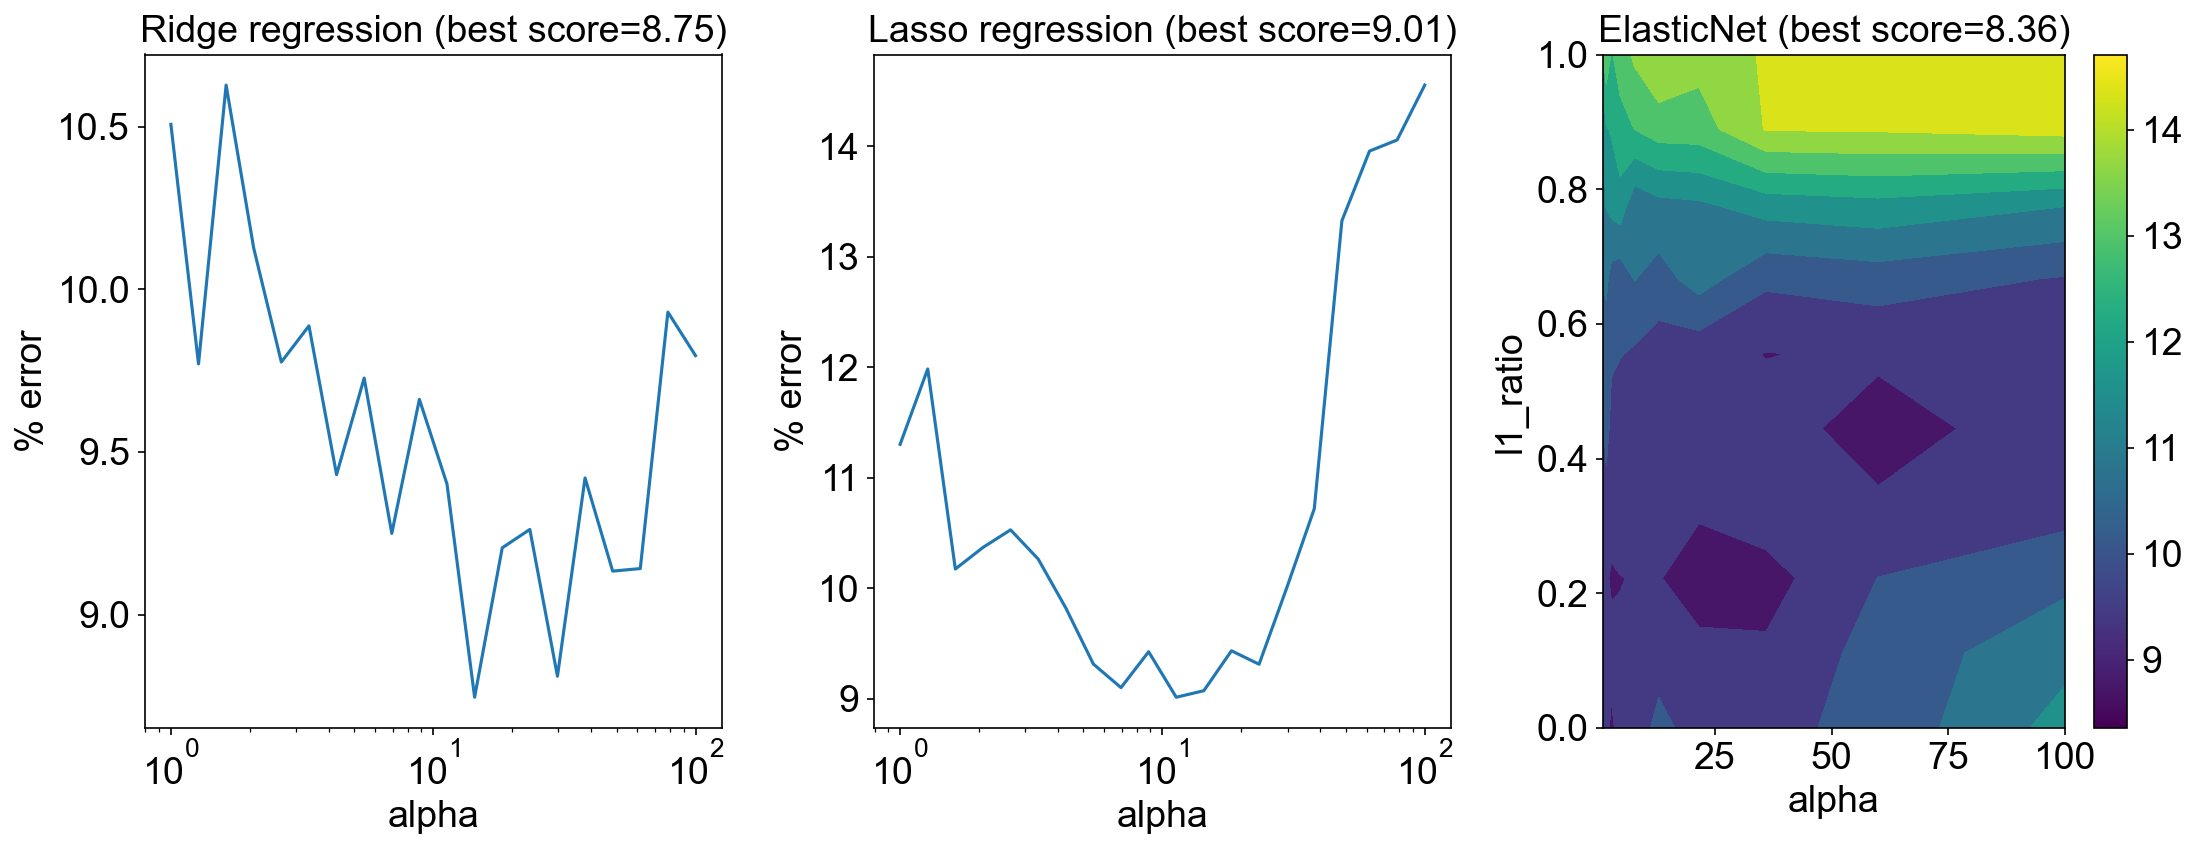

In [32]:
def plot_gridsearch(gridsearch):
    fig, axes = plt.subplots(1,3,figsize=(15,6))

    ax = axes[0]
    ax.semilogx(*gridsearch["Ridge"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Ridge regression (best score={np.min(gridsearch['Ridge'][1]):.2f})")

    ax = axes[1]
    ax.semilogx(*gridsearch["Lasso"])
    ax.set_xlabel("alpha")
    ax.set_ylabel("% error")
    ax.set_title(f"Lasso regression (best score={np.min(gridsearch['Lasso'][1]):.2f})")

    ax = axes[2]
    ax.contourf(*gridsearch["ElasticNet"])
    ax.set_title(f"ElasticNet (best score={np.min(gridsearch['ElasticNet'][2]):.2f})")
    ax.set_xlabel("alpha")
    ax.set_ylabel("l1_ratio")
    vmin = np.min(gridsearch['ElasticNet'][2])
    vmax = np.max(gridsearch['ElasticNet'][2])
    plt.colorbar(cm.ScalarMappable(colors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)

    fig.tight_layout()
    return fig

fig = plot_gridsearch(gridsearch)
fig.savefig(OUTPUT_DIR + "manual_gridsearch.pdf")

### Manual, high corr features

In [33]:
gridsearch_highcorr = manual_gridsearch(high_corr_form_features, yvar70)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.440549552497032, tolerance: 5.341173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.52424186434655, tolerance: 6.337973333333336
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.302174593076415, tolerance: 5.058493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13827.65018056155, tolerance: 6.366293333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14002.754961613062, tolerance: 7.25464
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8757.759687806127, tolerance: 5.289773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14904.459023708163, tolerance: 7.564373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15492.966603910545, tolerance: 7.431933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7509.41635510511, tolerance: 4.520040000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12805.664876327604, tolerance: 7.521173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9834.561864371477, tolerance: 5.293693333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13200.54727549167, tolerance: 6.646573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8431.845121688544, tolerance: 5.990773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15654.760398758055, tolerance: 7.832893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15589.609691032912, tolerance: 6.388533333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7016.917818411874, tolerance: 5.3112
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14924.8360938377, tolerance: 7.000773333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9024.339377459715, tolerance: 5.822093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converg

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15950.13818702818, tolerance: 6.9719733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15113.108528123605, tolerance: 6.366293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15544.13666043767, tolerance: 7.146373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9974.311315450475, tolerance: 6.0726933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15941.953480783604, tolerance: 8.202693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17652.016850267344, tolerance: 7.288160000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16546.54753125314, tolerance: 5.985600000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16245.10791920031, tolerance: 6.978240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10051.60116850626, tolerance: 5.112240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10455.294770419616, tolerance: 5.1858933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17514.521601104097, tolerance: 7.052560000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17555.44354093712, tolerance: 6.672573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17973.4082984303, tolerance: 7.420373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12163.095543648518, tolerance: 5.816933333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16616.512926263087, tolerance: 7.1761333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20118.292061550423, tolerance: 7.241440000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18984.703795960915, tolerance: 7.3234400000000015
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18742.37716527277, tolerance: 6.81684
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21306.212712728884, tolerance: 7.197493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20871.56831528762, tolerance: 7.018133333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19487.336878466376, tolerance: 6.943893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22351.04168860167, tolerance: 7.06144
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22582.7335026156, tolerance: 7.386133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19945.80783107257, tolerance: 6.875893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conver

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22672.47657468119, tolerance: 6.555933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13896.09763690161, tolerance: 4.3752933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24645.18997410732, tolerance: 7.575893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25036.689718590827, tolerance: 7.66184
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21955.053976408028, tolerance: 6.282893333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23008.926470758997, tolerance: 6.547173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25574.26864912647, tolerance: 7.023733333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24855.856714388843, tolerance: 6.684933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17894.919847440768, tolerance: 5.040493333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25995.147643901226, tolerance: 6.826293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26268.345674134373, tolerance: 7.245840000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19506.074253124545, tolerance: 5.308133333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27775.052460388502, tolerance: 6.89096
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30650.8222643172, tolerance: 7.51784
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26923.772994719555, tolerance: 6.406293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30590.547480466434, tolerance: 7.370893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29822.13448525755, tolerance: 7.126573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26724.087856492053, tolerance: 6.547493333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31689.86278794273, tolerance: 7.304240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34922.85678723756, tolerance: 8.103560000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29530.642103212016, tolerance: 6.693440000000002
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30708.09414886137, tolerance: 7.039973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26624.695544372807, tolerance: 5.92916
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35229.836163476364, tolerance: 8.266160000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34790.084174635755, tolerance: 7.606573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32703.63526097873, tolerance: 7.088373333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28655.558025569426, tolerance: 6.207373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32360.307643772052, tolerance: 7.045040000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31374.140180687617, tolerance: 6.827973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34318.80258891445, tolerance: 7.545093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

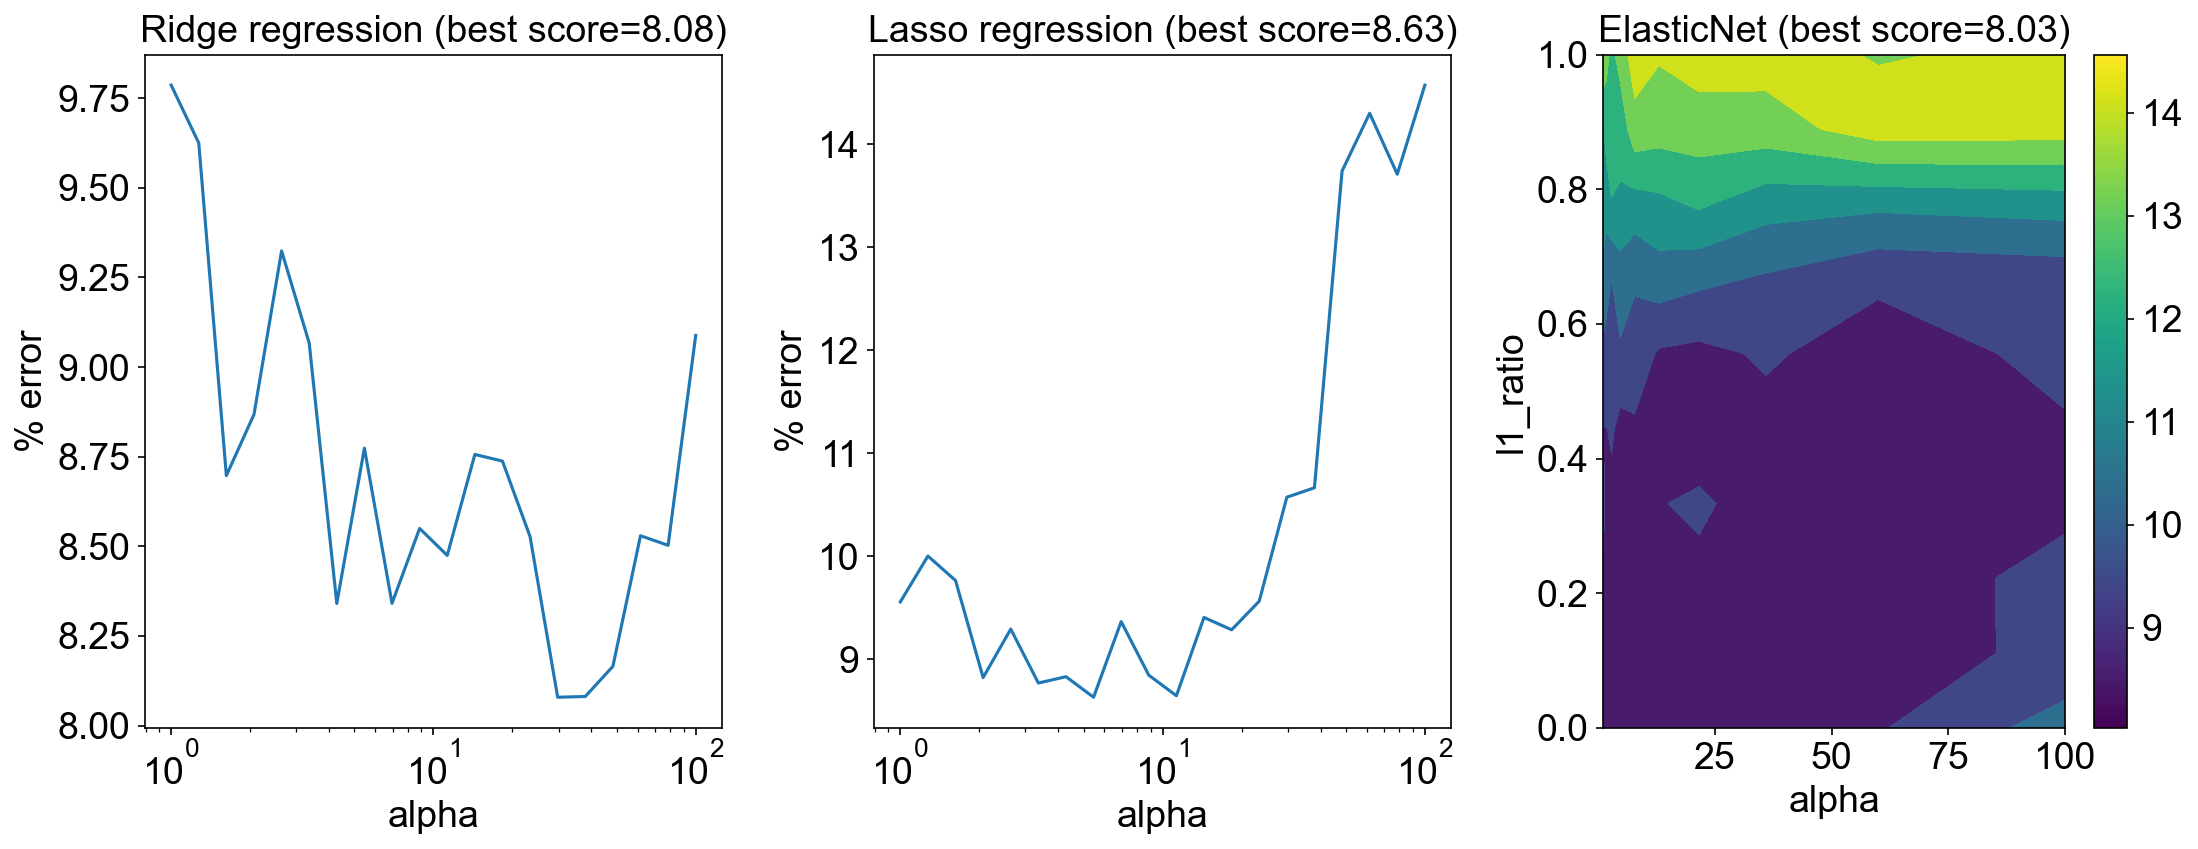

In [34]:
fig = plot_gridsearch(gridsearch_highcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_highcorr.pdf")

0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24042.543161670572, tolerance: 7.1251733333333345
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26133.309748099306, tolerance: 8.163
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21032.419317354874, tolerance: 5.953373333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26043.40460059787, tolerance: 6.906773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25829.433241517385, tolerance: 6.828573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25970.216228152447, tolerance: 7.074240000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23909.030211296715, tolerance: 6.036693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31756.40235241274, tolerance: 7.962173333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25866.42899312214, tolerance: 6.150573333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33165.092323652636, tolerance: 8.084293333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22021.8804191481, tolerance: 5.49816
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17929.431723663332, tolerance: 4.352573333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32440.504925998983, tolerance: 7.439893333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31530.165467595452, tolerance: 7.089173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25202.06566036241, tolerance: 5.901173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31024.475709177583, tolerance: 6.67036
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35270.75622118224, tolerance: 7.628773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35343.63592742878, tolerance: 7.71044
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You 

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32045.638469638132, tolerance: 6.73044
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31661.25602429899, tolerance: 6.613973333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24669.801510195433, tolerance: 5.241293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29812.849390053398, tolerance: 6.114773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36191.28722972765, tolerance: 7.473493333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24335.928904995904, tolerance: 5.021373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25726.52736259407, tolerance: 5.247973333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37149.37668501439, tolerance: 7.562773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38317.628339699215, tolerance: 7.819693333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37230.7812099063, tolerance: 7.5266
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27795.072160658936, tolerance: 5.633333333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20834.841893284218, tolerance: 4.214733333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38220.343347179005, tolerance: 7.697173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31068.296260828272, tolerance: 6.251293333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36238.64377800041, tolerance: 7.2936000000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

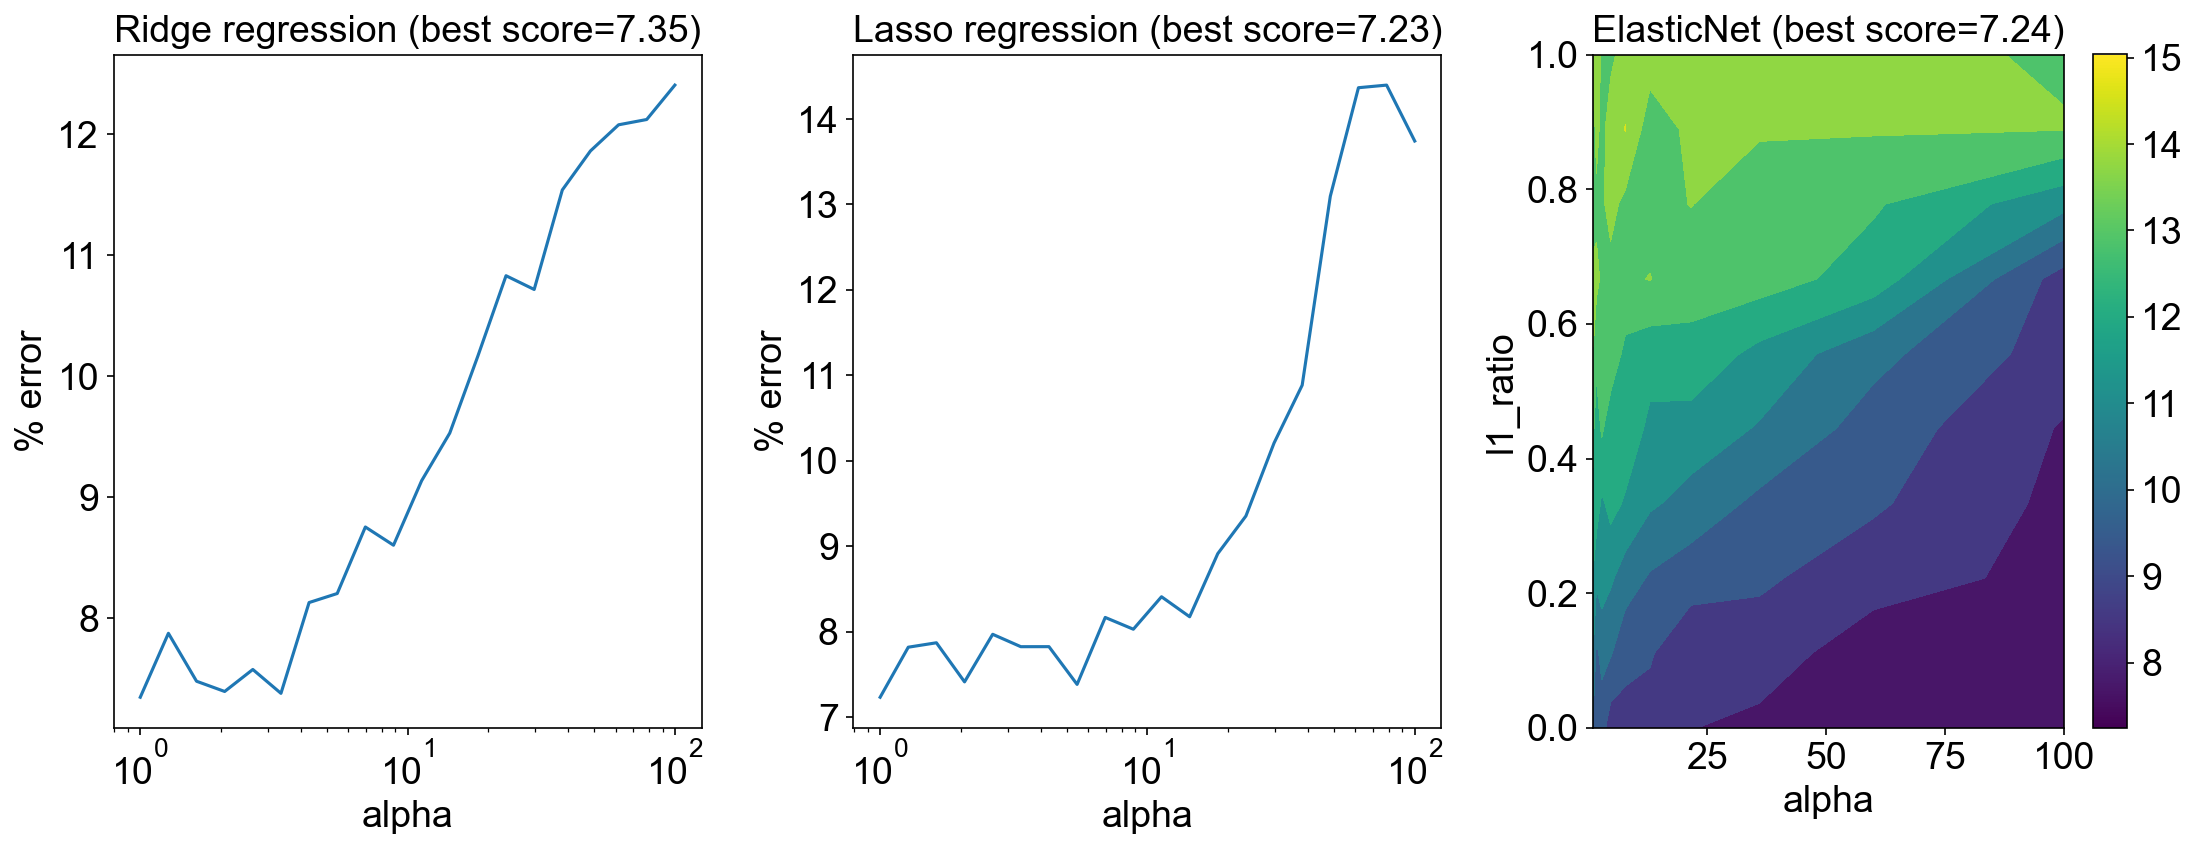

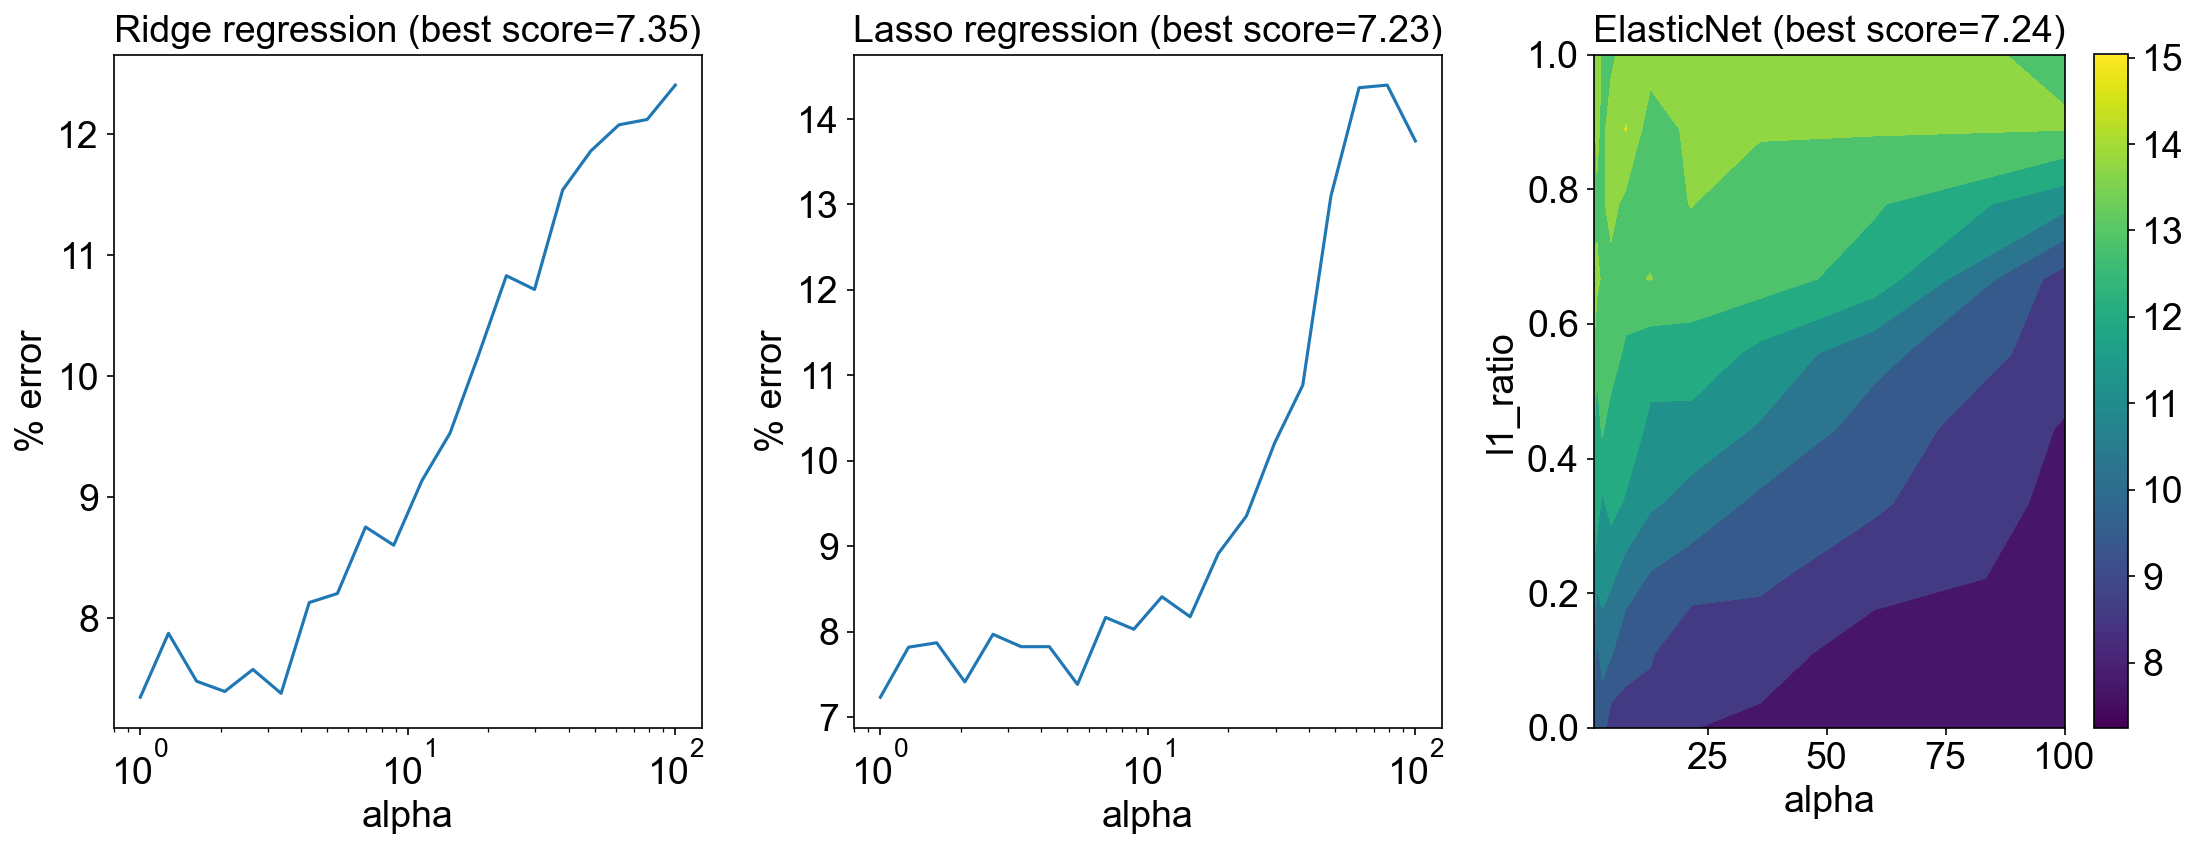

In [35]:
plot_gridsearch(manual_gridsearch("form_first_discharge_capacity_ah", yvar70))

### Manual, very high corr

In [36]:
gridsearch_veryhighcorr = manual_gridsearch(very_high_corr_form_features, yvar70)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.294204176487256, tolerance: 5.123773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.361883792846129, tolerance: 5.87324
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.292249156680555, tolerance: 5.320173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.684816487611897, tolerance: 6.005093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.155262332562415, tolerance: 5.500639999999999
  model = cd_fast.enet_coordinate_descent(


0


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13258.193715541525, tolerance: 8.278293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14766.459313233398, tolerance: 6.882960000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15100.161012823624, tolerance: 7.609933333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10572.202452618847, tolerance: 4.854773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15258.903220419972, tolerance: 7.341600000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14287.361749855902, tolerance: 5.795733333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

1


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15543.80910969521, tolerance: 6.251293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16492.289380051225, tolerance: 6.326933333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16045.32714087747, tolerance: 6.329159999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective di

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.541704808723807, tolerance: 5.174573333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.9701708685825, tolerance: 5.452293333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19779.654637900625, tolerance: 6.759893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did 

2


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20043.816041962597, tolerance: 7.114959999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11681.828503846917, tolerance: 4.504893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18630.785627688485, tolerance: 7.784640000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.09954141581693, tolerance: 4.5654
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.77092569460001, tolerance: 5.320173333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21580.124780927064, tolerance: 6.760533333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converg

3


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21254.15884767931, tolerance: 6.605773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23544.43447883738, tolerance: 7.9175733333333325
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22229.547586884484, tolerance: 7.359093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.134735912513861, tolerance: 4.683773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.656758867704411, tolerance: 5.492373333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.050556383092044, tolerance: 5.597293333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

4


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23961.00191641914, tolerance: 7.189973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25271.307775270307, tolerance: 7.260693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26487.428366128188, tolerance: 7.389893333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.750806733951322, tolerance: 5.7236
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29630.59585267516, tolerance: 7.410133333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16059.550289673338, tolerance: 4.1141733333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conv

5


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28492.450393114017, tolerance: 7.5224
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28149.363689998932, tolerance: 7.364693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19847.759209325744, tolerance: 5.081093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not con

6


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24612.01207803236, tolerance: 5.814773333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22893.151351204666, tolerance: 5.364733333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30157.207915194933, tolerance: 7.025093333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28404.430295702205, tolerance: 6.511773333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31786.822491957326, tolerance: 7.601773333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22198.44243881553, tolerance: 5.218933333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

7


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32722.202296650044, tolerance: 7.216559999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31549.699583447924, tolerance: 6.922640000000001
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27131.316560251063, tolerance: 6.169973333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35084.52976553099, tolerance: 7.7942399999999985
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33093.11239514672, tolerance: 7.384373333333335
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30053.28737014846, tolerance: 6.5964
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not conve

8


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22520.70259280858, tolerance: 4.799573333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34313.83605873992, tolerance: 7.351173333333333
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31475.950198567578, tolerance: 6.6703600000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective d

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30745.691035914228, tolerance: 6.516093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31494.583853593467, tolerance: 6.6664400000000015
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23231.837712791465, tolerance: 4.948973333333332
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

9


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33407.99512838018, tolerance: 6.92744
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33053.932624358145, tolerance: 6.897773333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26057.197443098652, tolerance: 5.4161600000000005
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not co

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32853.43795557226, tolerance: 6.818639999999999
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36707.08183370408, tolerance: 7.676693333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34967.55716230803, tolerance: 7.303093333333334
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did

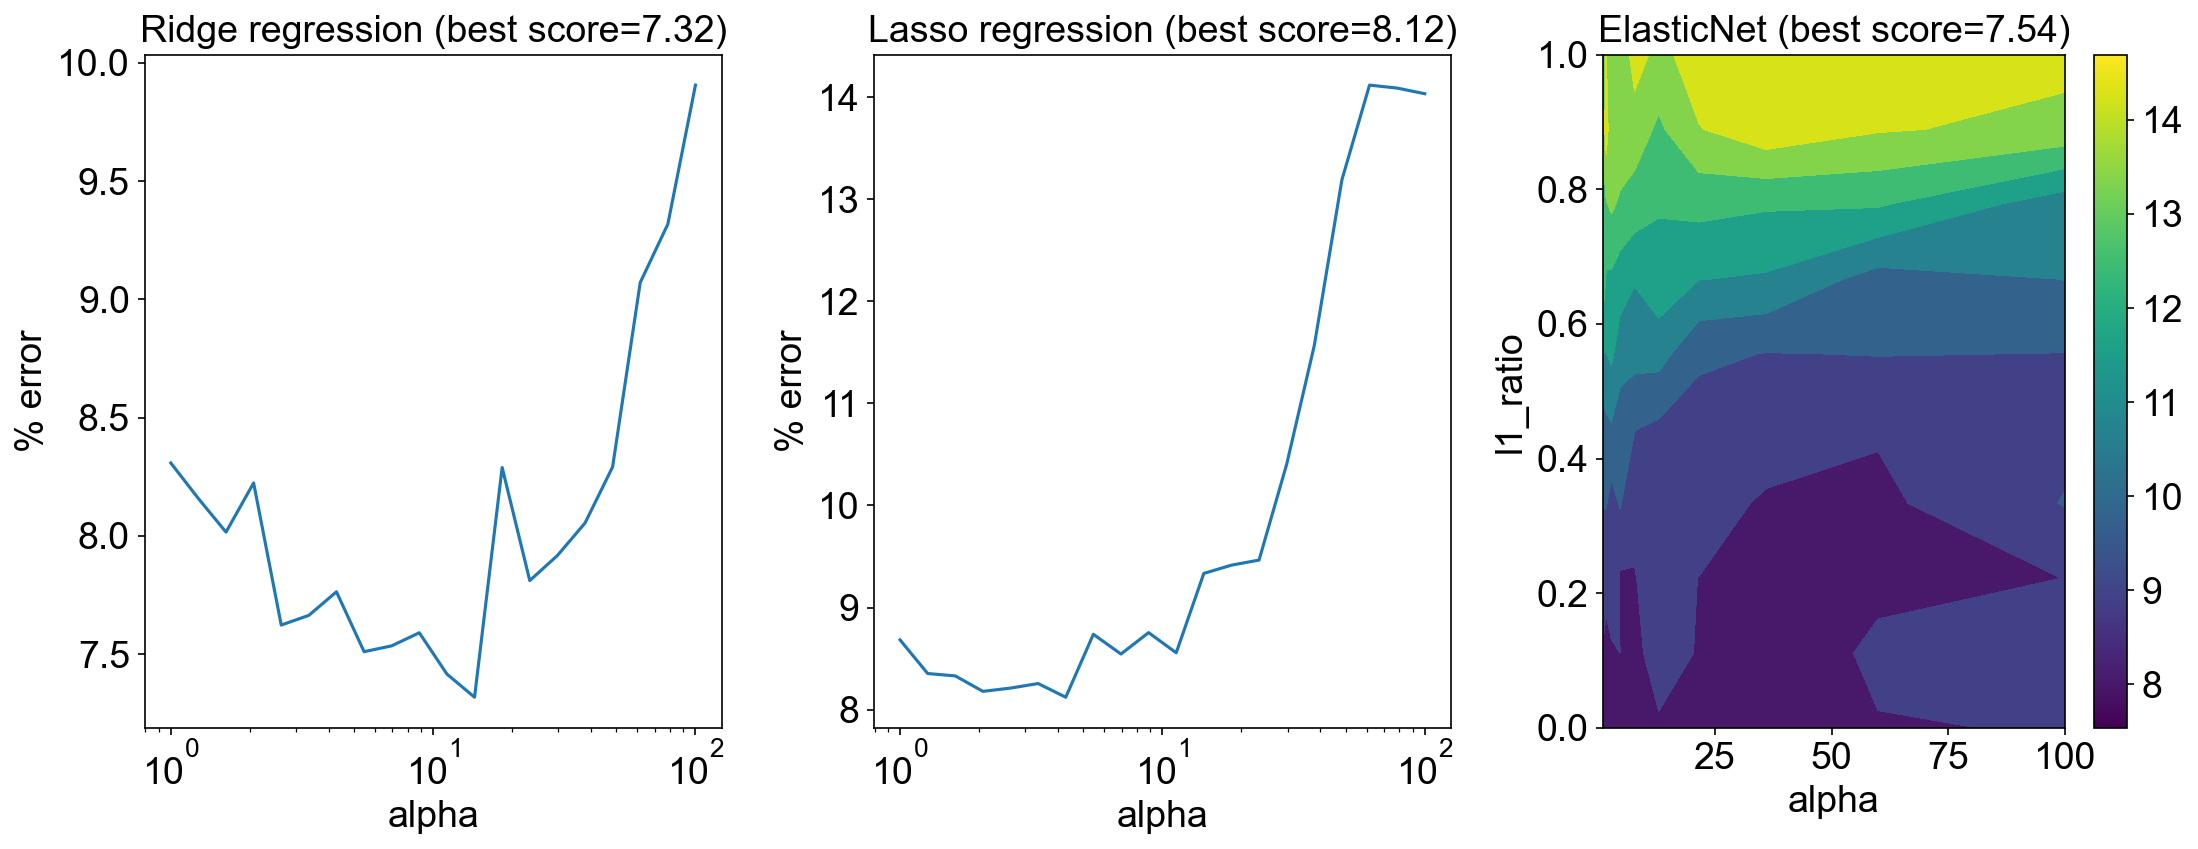

In [37]:
fig = plot_gridsearch(gridsearch_veryhighcorr)
fig.savefig(OUTPUT_DIR + "manual_gridsearch_veryhighcorr.pdf")

In [38]:
yvar

'cycles_to_70_pct'

## Printing lots of models

In [39]:
def print_model(model, yvar, **kwargs):
    print(model)
    print("Label: ", yvar)
    for f in very_high_corr_form_features:
        out = train_and_test_model(df, f, yvar, to_plot=0, model=LinearRegression(), num_experiments=1000,
                                  **kwargs)
        print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    
    out = train_and_test_model(df, f, yvar, to_plot=0, model=DummyRegressor(), num_experiments=1000,
                              **kwargs)
    print(f"{'Dummy regressor (predict mean)':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'very high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, high_corr_form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'high corr':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model, num_experiments=1000,
                              **kwargs)
    print(f"{'all':<40}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    # out = train_and_test_model(df, very_high_corr_form_features, yvar, to_plot=0, model=Lasso(5), num_experiments=1000)
    # print(f"{'Lasso(5), very high corr':<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    

In [40]:
print_model(ElasticNet(alpha=50, l1_ratio=0.3), yvar70)

ElasticNet(alpha=50, l1_ratio=0.3)
Label:  cycles_to_70_pct
form_first_discharge_capacity_below_3p2v_ah       7.78 (2.57 std)
form_last_charge_voltage_after_1s                 7.42 (2.49 std)
form_last_charge_voltage_after_60s                7.83 (2.70 std)
form_first_discharge_capacity_ah                  7.40 (2.44 std)
form_first_cycle_efficiency                       7.35 (2.42 std)
form_c20_charge_right_peak_v_per_ah               8.30 (2.68 std)
Dummy regressor (predict mean)          14.35 (3.97 std)
very high corr                          13.21 (3.93 std)
high corr                               12.24 (3.72 std)
all                                     11.90 (3.81 std)


In [41]:
print_model(Ridge(10), yvar50)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.31 (2.48 std)
form_last_charge_voltage_after_1s                 7.24 (2.41 std)
form_last_charge_voltage_after_60s                7.00 (2.31 std)
form_first_discharge_capacity_ah                  6.98 (2.31 std)
form_first_cycle_efficiency                       7.24 (2.43 std)
form_c20_charge_right_peak_v_per_ah               8.18 (2.35 std)
Dummy regressor (predict mean)          12.76 (3.14 std)
very high corr                          7.35 (2.26 std)
high corr                               7.56 (2.43 std)
all                                     9.16 (2.64 std)


In [42]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=False)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.33 (2.44 std)
form_last_charge_voltage_after_1s                 7.28 (2.52 std)
form_last_charge_voltage_after_60s                7.10 (2.26 std)
form_first_discharge_capacity_ah                  7.12 (2.40 std)
form_first_cycle_efficiency                       7.07 (2.29 std)
form_c20_charge_right_peak_v_per_ah               7.98 (2.19 std)
Dummy regressor (predict mean)          12.73 (3.20 std)
very high corr                          7.37 (2.31 std)
high corr                               7.62 (2.40 std)
all                                     8.97 (2.74 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.46 (2.58 std)
form_last_charge_voltage_after_1s                 7.35 (2.49 std)
form_last_charge_voltage_after_60s                7.50 (2.53 std)
form_first_discharge_capacity_ah                  7.37 (2.51 std)
form_first_cycle_efficiency      

In [43]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, log=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.22 (2.38 std)
form_last_charge_voltage_after_1s                 7.19 (2.38 std)
form_last_charge_voltage_after_60s                6.95 (2.23 std)
form_first_discharge_capacity_ah                  7.11 (2.48 std)
form_first_cycle_efficiency                       7.08 (2.39 std)
form_c20_charge_right_peak_v_per_ah               8.03 (2.24 std)
Dummy regressor (predict mean)          12.66 (3.03 std)
very high corr                          7.25 (2.27 std)
high corr                               7.51 (2.36 std)
all                                     8.63 (2.59 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.43 (2.45 std)
form_last_charge_voltage_after_1s                 7.42 (2.61 std)
form_last_charge_voltage_after_60s                7.41 (2.50 std)
form_first_discharge_capacity_ah                  7.22 (2.54 std)
form_first_cycle_efficiency      

In [44]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, square=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.56 (2.72 std)
form_last_charge_voltage_after_1s                 7.32 (2.40 std)
form_last_charge_voltage_after_60s                7.33 (2.34 std)
form_first_discharge_capacity_ah                  7.26 (2.37 std)
form_first_cycle_efficiency                       7.25 (2.36 std)
form_c20_charge_right_peak_v_per_ah               8.17 (2.35 std)
Dummy regressor (predict mean)          12.80 (3.30 std)
very high corr                          7.53 (2.31 std)
high corr                               7.89 (2.40 std)
all                                     9.63 (2.89 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.78 (2.75 std)
form_last_charge_voltage_after_1s                 7.51 (2.48 std)
form_last_charge_voltage_after_60s                7.69 (2.54 std)
form_first_discharge_capacity_ah                  7.39 (2.48 std)
form_first_cycle_efficiency      

In [45]:
for yvar in [yvar50, yvar60, yvar70, yvar80]:
    print_model(Ridge(10), yvar, sqrt=True)

Ridge(alpha=10)
Label:  cycles_to_50_pct
form_first_discharge_capacity_below_3p2v_ah       7.25 (2.48 std)
form_last_charge_voltage_after_1s                 7.18 (2.41 std)
form_last_charge_voltage_after_60s                7.07 (2.34 std)
form_first_discharge_capacity_ah                  7.07 (2.35 std)
form_first_cycle_efficiency                       7.01 (2.30 std)
form_c20_charge_right_peak_v_per_ah               7.88 (2.22 std)
Dummy regressor (predict mean)          12.71 (2.98 std)
very high corr                          7.38 (2.30 std)
high corr                               7.55 (2.47 std)
all                                     8.72 (2.53 std)
Ridge(alpha=10)
Label:  cycles_to_60_pct
form_first_discharge_capacity_below_3p2v_ah       7.38 (2.63 std)
form_last_charge_voltage_after_1s                 7.41 (2.59 std)
form_last_charge_voltage_after_60s                7.27 (2.49 std)
form_first_discharge_capacity_ah                  7.30 (2.45 std)
form_first_cycle_efficiency      

## PCA

In [46]:
df_form.corr()["form_first_discharge_capacity_ah"].sort_values()

form_last_charge_voltage_after_60s            -0.980428
form_6hr_rest_delta_voltage_v_0_to_3_hr       -0.916951
form_6hr_rest_delta_voltage_v_0_to_2_hr       -0.915978
form_6hr_rest_delta_voltage_v_0_to_4_hr       -0.913766
form_6hr_rest_delta_voltage_v_0_to_1_hr       -0.904858
form_6hr_rest_delta_voltage_v_0_to_5_hr       -0.903710
form_c20_charge_right_peak_v_per_ah           -0.898403
form_6hr_rest_delta_voltage_v_0_to_6_hr       -0.893952
form_6hr_rest_delta_voltage_v                 -0.890137
cycles_to_70_pct                              -0.822596
form_6hr_rest_delta_voltage_v_1_to_6_hr       -0.789071
cycles_to_80_pct                              -0.788770
cycles_to_60_pct                              -0.785245
cycles_to_50_pct                              -0.782680
form_6hr_rest_delta_voltage_v_2_to_6_hr       -0.692257
form_6hr_rest_delta_voltage_v_3_to_6_hr       -0.634634
form_6hr_rest_delta_voltage_v_4_to_6_hr       -0.598132
form_6hr_rest_delta_voltage_v_5_to_6_hr       -0

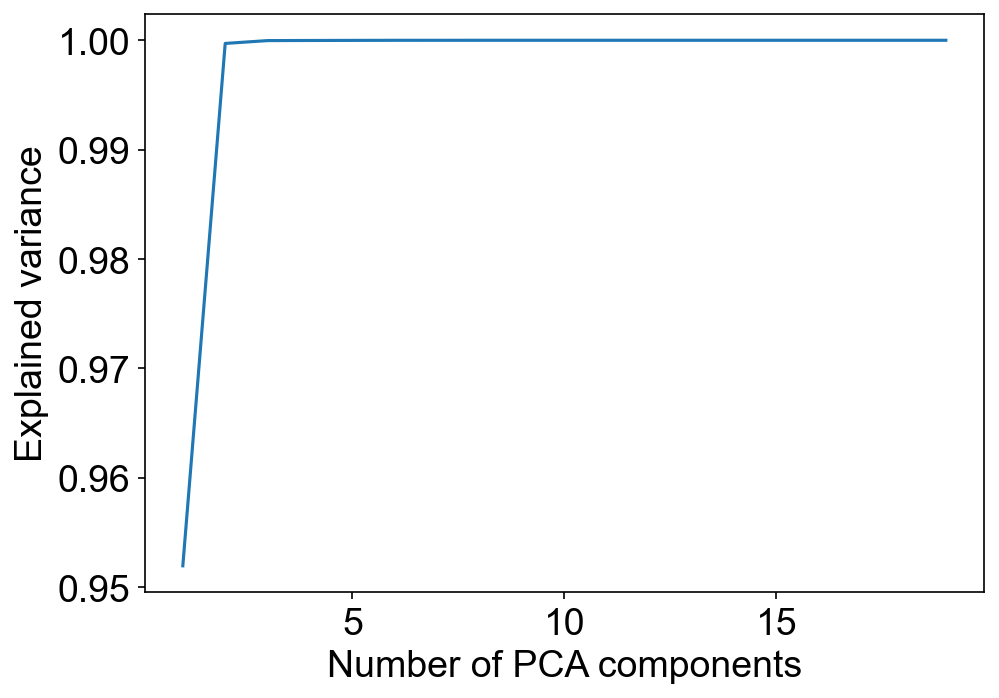

In [47]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_form[form_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1,len(cumsum)+1),cumsum)
ax.set_xlabel("Number of PCA components")
ax.set_ylabel("Explained variance")
fig.savefig(OUTPUT_DIR + "pca.pdf")

In [48]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = very_high_corr_form_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

7.293470289911103

## Understanding the model

See https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html 

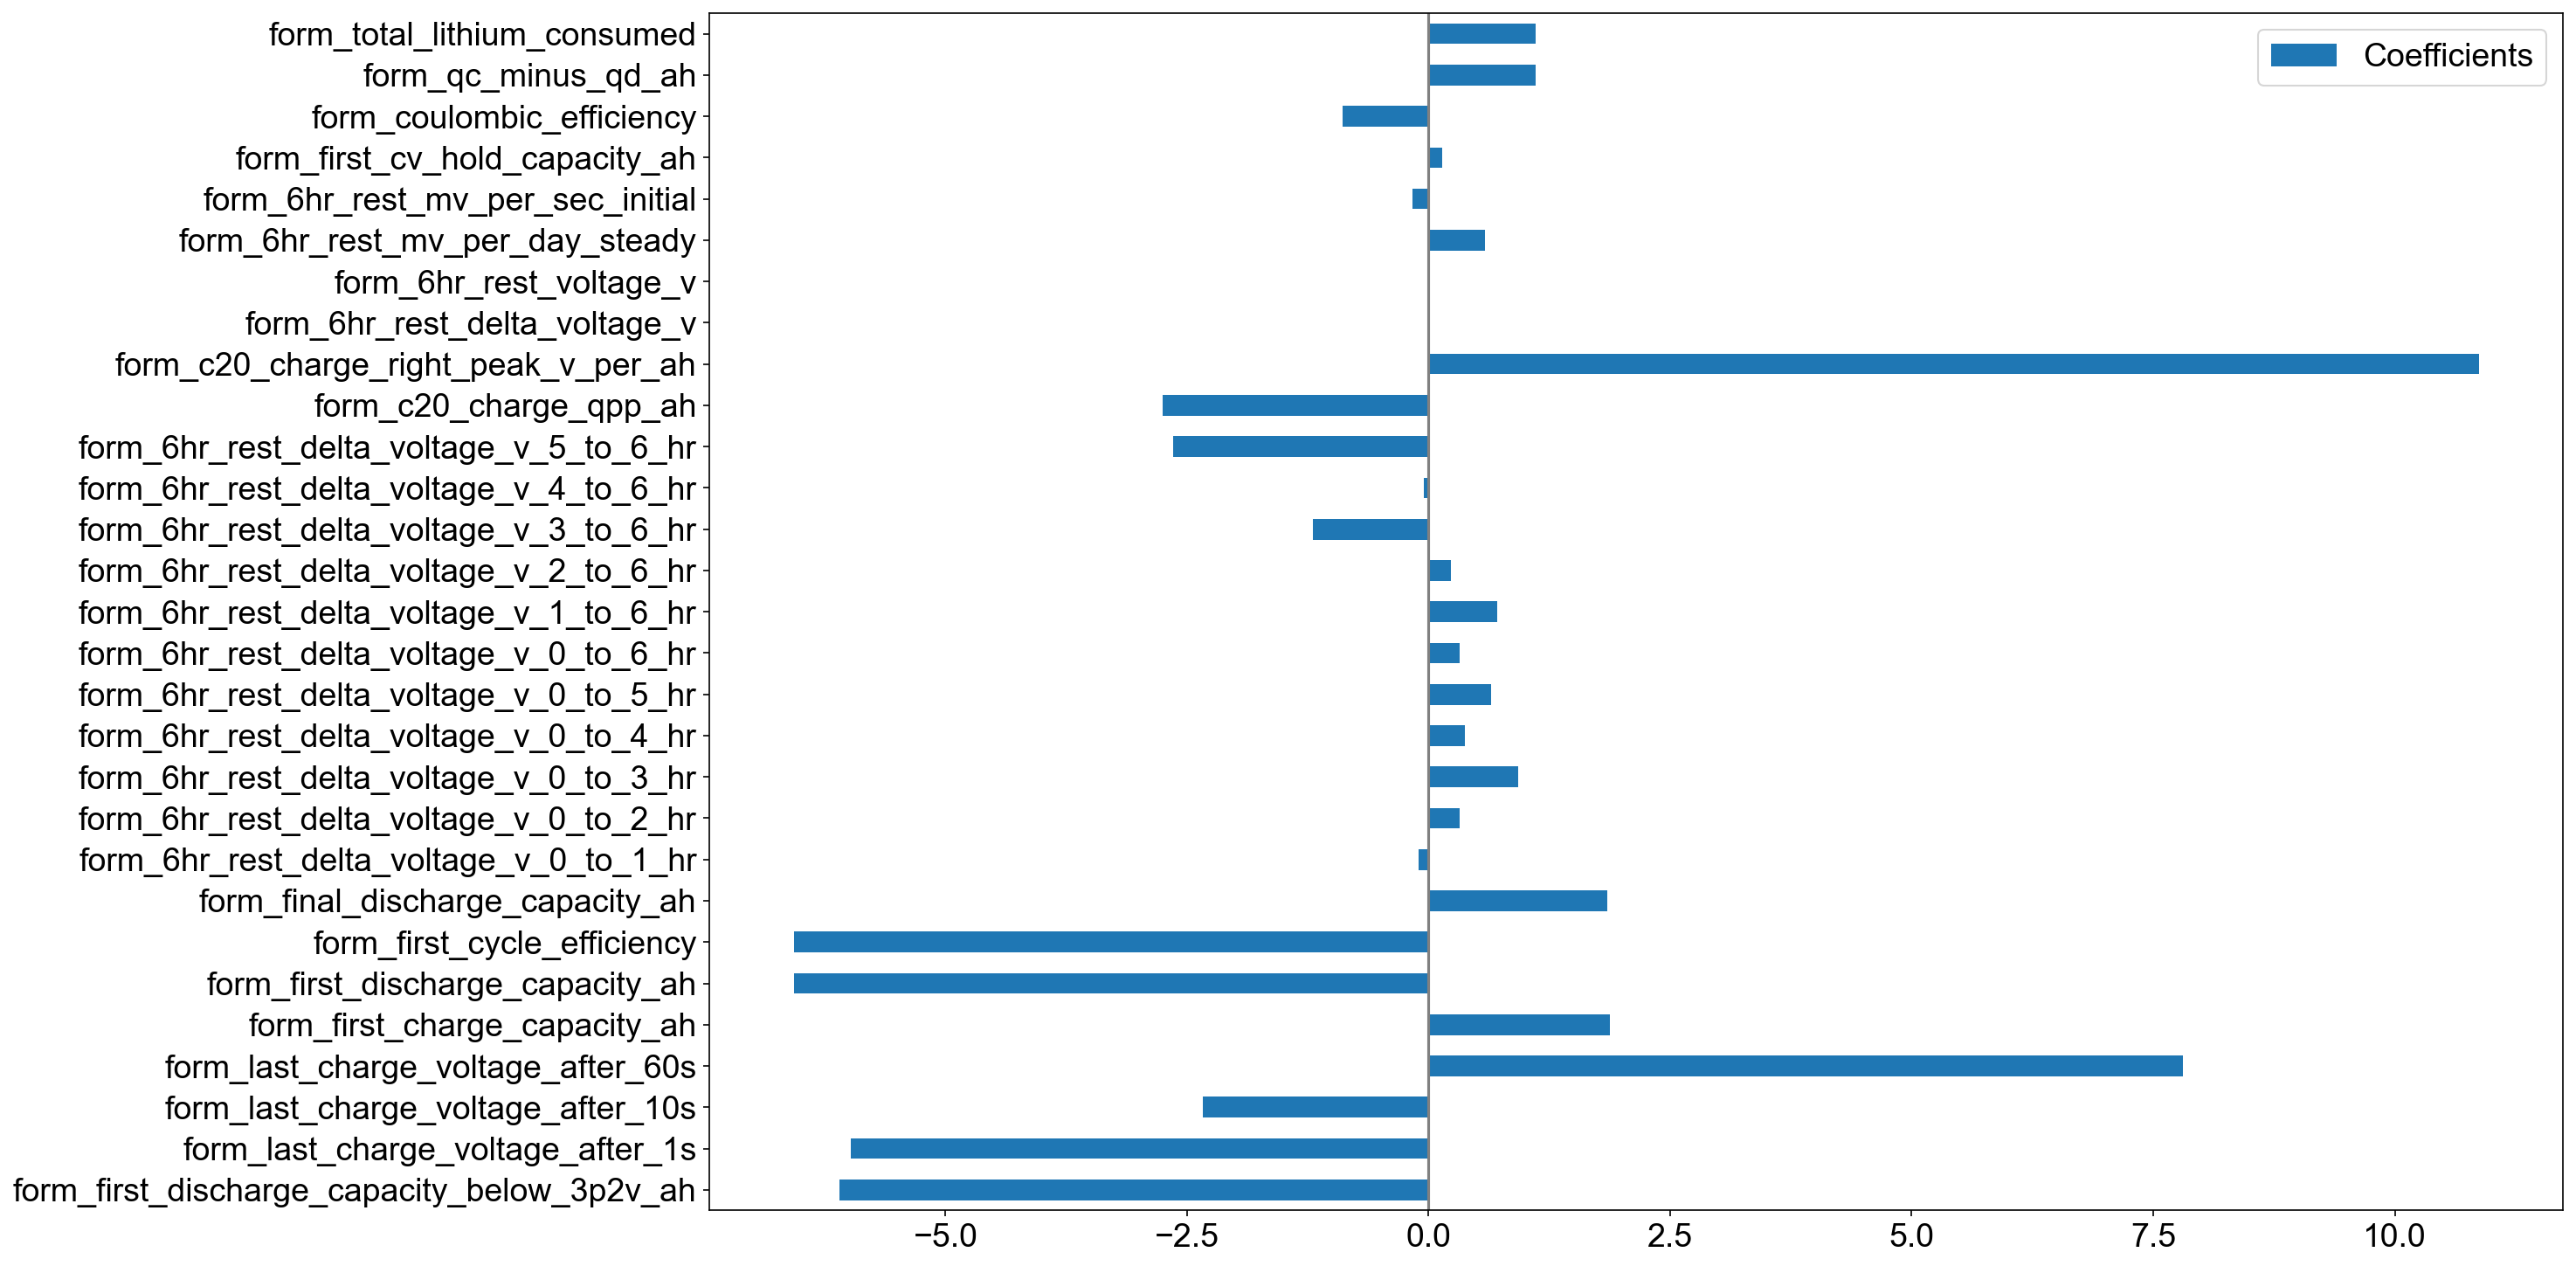

In [49]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(alpha_ridge)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')

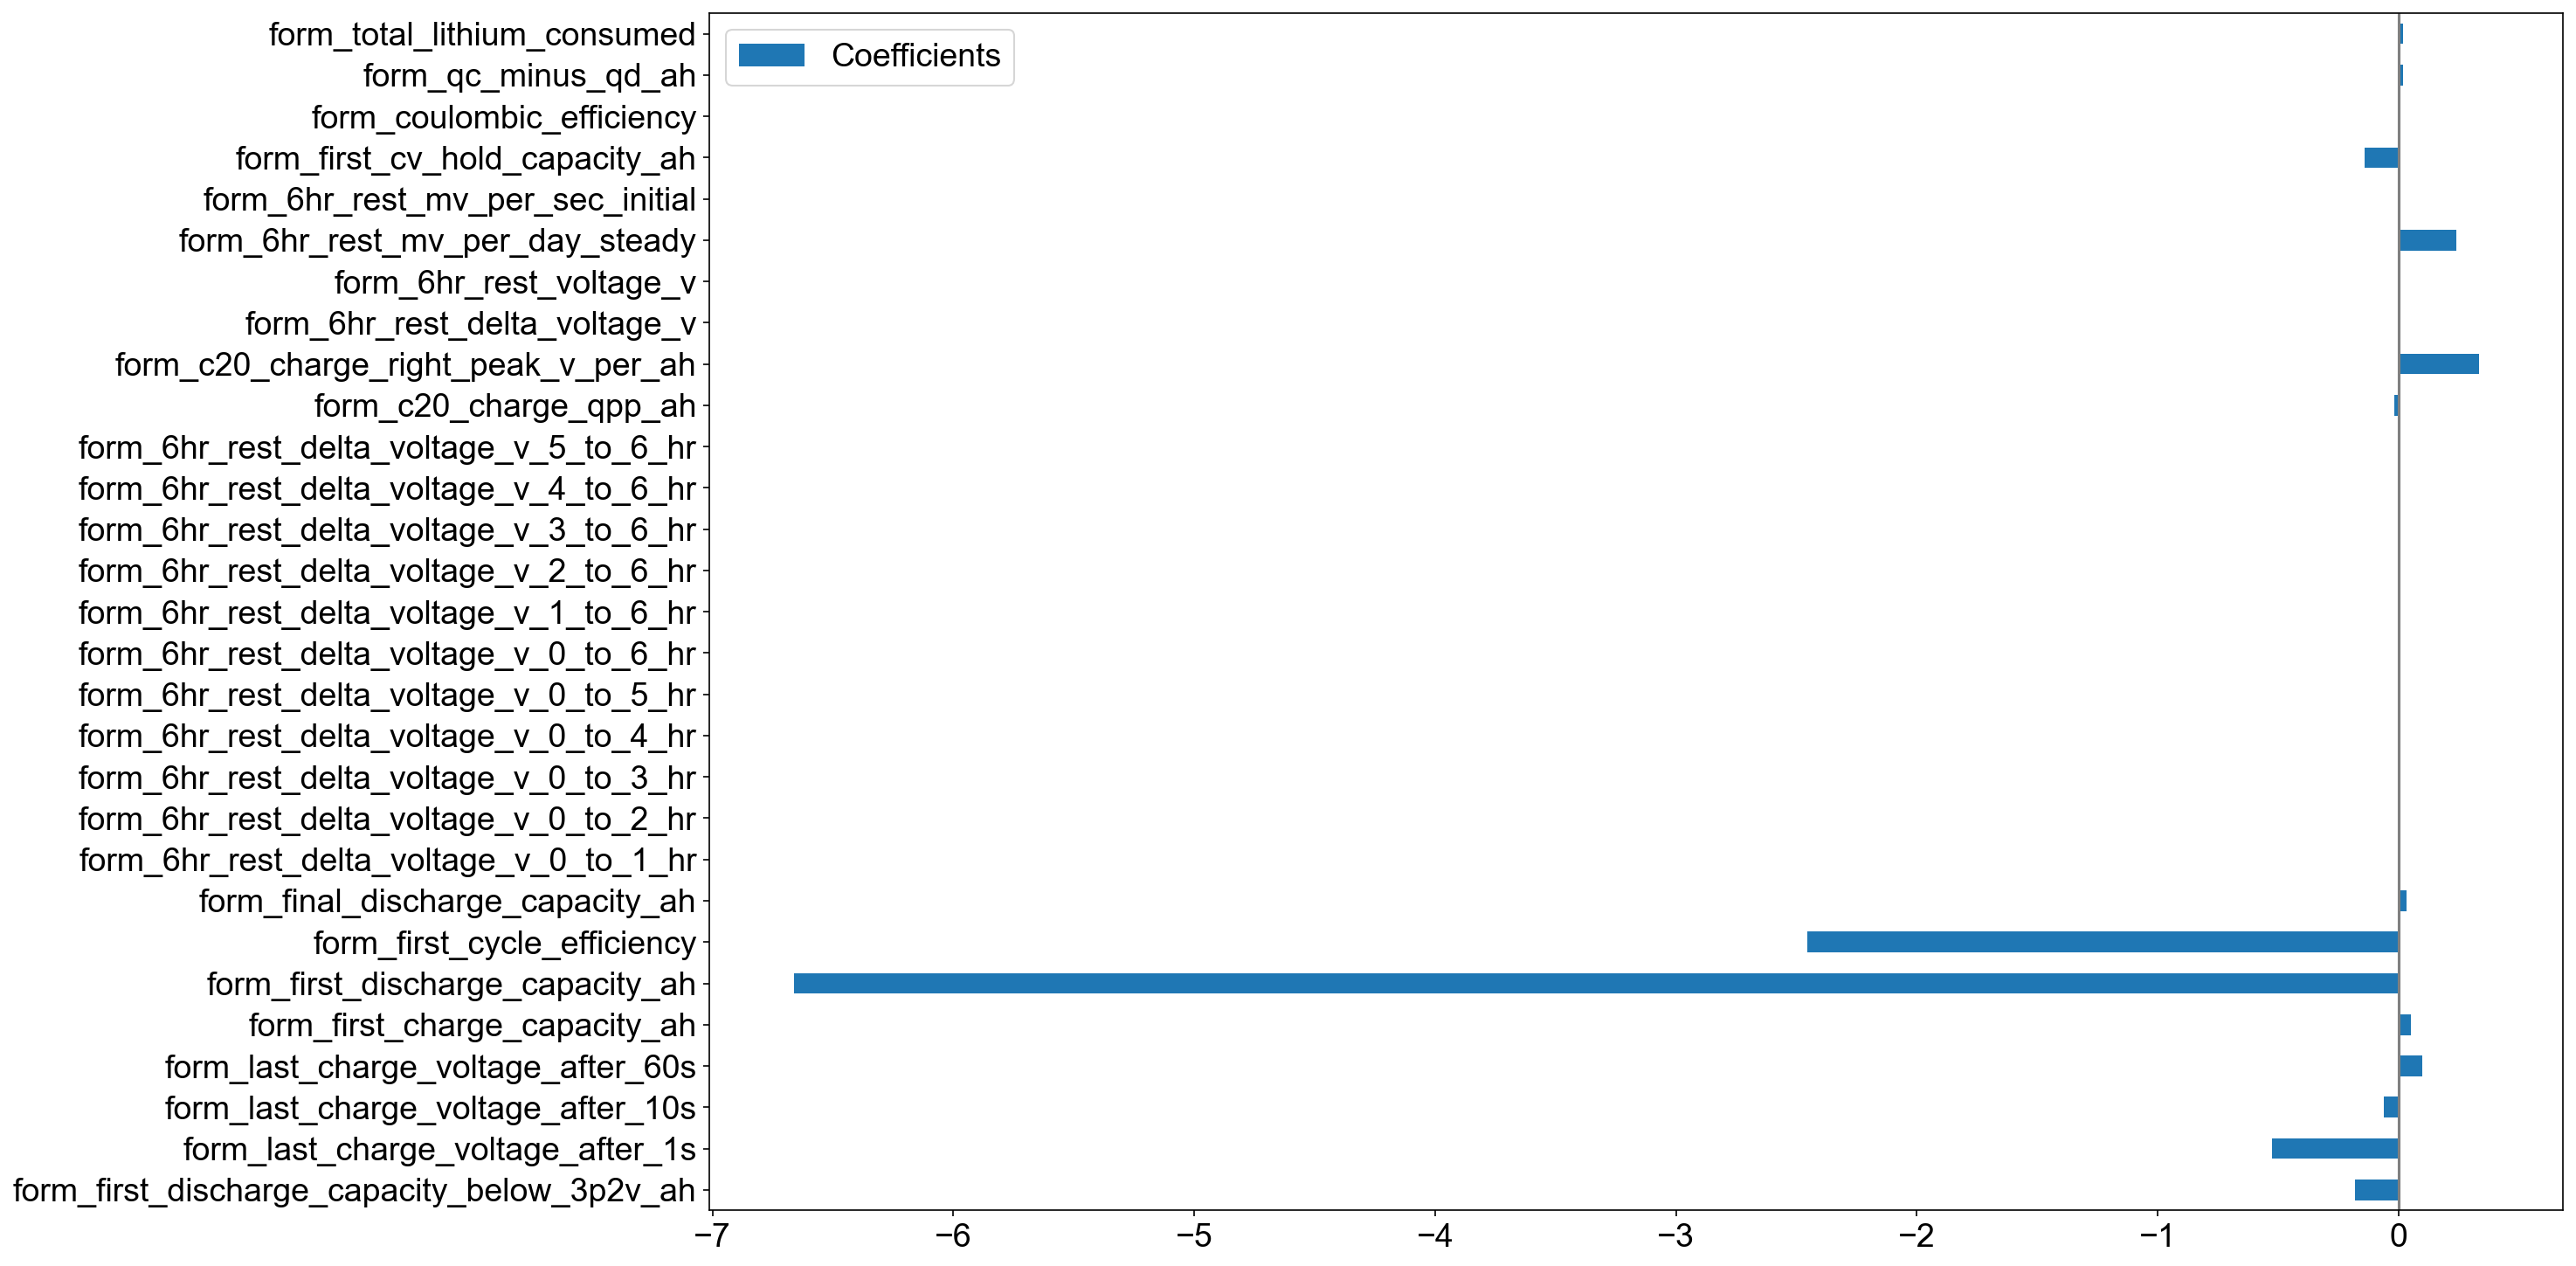

In [50]:
ridge = gridsearch["Ridge"]
alpha_ridge = ridge[0][np.argmin(ridge[1])]
model = Ridge(10)
out = train_and_test_model(df, form_features, yvar, to_plot=0, model=model)
coefs = pd.DataFrame(
    model.coef_ * df[form_features].std(axis=0),
    columns=['Coefficients'], index=out["features"]
)
coefs.plot(kind="barh",figsize=(20,10))
plt.axvline(x=0, color='.5')
plt.savefig(OUTPUT_DIR + "model_coeffs.png")


In [51]:
feat = ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency"]#, "form_6hr_rest_mv_per_day_steady"]
out = train_and_test_model(df, feat, yvar70, to_plot=0, model=Ridge(10), num_experiments=1000, log=True)
print(f"{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

7.95 (2.59 std)


In [52]:
out = train_and_test_model(df, ["form_first_discharge_capacity_ah", "form_first_cycle_efficiency", "form_6hr_rest_mv_per_day_steady"],
                                yvar70, to_plot=0, model=ElasticNet(alpha=0.01,l1_ratio=0.3), num_experiments=1000,
                                  log=True)
print(f"{f:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

form_total_lithium_consumed                       7.65 (2.65 std)


# Including features up to cycle 3

In [53]:
c3_select = lambda x: ((x.endswith("_c3") or x.startswith("esoh_c3_") or x.startswith("rpt_c3_"))
                       and not any(s in x for s in ["LLI", "LAM", "Qcomp", "C20_loss"]))
c3_features = list(filter(c3_select, df.columns))
label_select = lambda x: x.startswith("cycles_to_")
labels = list(filter(label_select, df.columns))
df_c3 = df[c3_features + labels]
df_c3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 38
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retention_at_c3        19 non-null     float64
 1   dcr_10s_0_soc_at_c3    19 non-null     float64
 2   dcr_3s_0_soc_at_c3     19 non-null     float64
 3   dcr_1s_0_soc_at_c3     19 non-null     float64
 4   dcr_10s_5_soc_at_c3    19 non-null     float64
 5   dcr_3s_5_soc_at_c3     19 non-null     float64
 6   dcr_1s_5_soc_at_c3     19 non-null     float64
 7   dcr_10s_7_soc_at_c3    19 non-null     float64
 8   dcr_3s_7_soc_at_c3     19 non-null     float64
 9   dcr_1s_7_soc_at_c3     19 non-null     float64
 10  dcr_10s_10_soc_at_c3   19 non-null     float64
 11  dcr_3s_10_soc_at_c3    19 non-null     float64
 12  dcr_1s_10_soc_at_c3    19 non-null     float64
 13  dcr_10s_15_soc_at_c3   19 non-null     float64
 14  dcr_3s_15_soc_at_c3    19 non-null     float64
 15  dcr_1s_1

In [54]:
df_c3.corr()[yvar50].sort_values(ascending=False)

cycles_to_50_pct       1.000000
cycles_to_60_pct       0.995579
cycles_to_70_pct       0.976940
cycles_to_80_pct       0.971337
esoh_c3_x100           0.812759
                         ...   
dcr_10s_5_soc_at_c3   -0.792791
esoh_c3_neg_excess    -0.829288
esoh_c3_Cn            -0.831686
esoh_c3_np_ratio      -0.845652
esoh_c3_CnCp          -0.845652
Name: cycles_to_50_pct, Length: 54, dtype: float64

In [55]:
for a in np.logspace(-2,2):
    out = train_and_test_model(df, ["esoh_c3_np_ratio"],#,"form_first_discharge_capacity_ah"], 
                               yvar, to_plot=0, model=Ridge(a), num_experiments=1000, log=True)
    print(f"{a:<50}{out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

0.01                                              8.00 (1.89 std)
0.012067926406393288                              8.09 (1.88 std)
0.014563484775012436                              8.01 (1.91 std)
0.017575106248547922                              8.06 (1.80 std)
0.021209508879201904                              7.95 (1.87 std)
0.025595479226995357                              8.08 (1.87 std)
0.030888435964774818                              7.99 (1.89 std)
0.0372759372031494                                7.96 (1.78 std)
0.04498432668969444                               8.11 (1.86 std)
0.054286754393238594                              8.00 (1.80 std)
0.0655128556859551                                7.94 (1.86 std)
0.07906043210907697                               8.03 (1.89 std)
0.09540954763499938                               7.97 (1.88 std)
0.1151395399326447                                8.05 (1.90 std)
0.13894954943731375                               8.04 (1.82 std)
0.16768329

PCA

In [56]:
pca = PCA()
pca.fit(df[form_features + c3_features])
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum[:3])
# fig, ax = plt.subplots()
# ax.plot(range(1,len(cumsum)+1),cumsum)
# ax.set_xlabel("Number of PCA components")
# ax.set_ylabel("Explained variance")
# fig.savefig(OUTPUT_DIR + "pca_with_c3.pdf")

[0.8425293  0.99323683 0.99993482]


So now we have two interesting directions

In [57]:
log = False
to_plot = False
yvar = yvar70
model = LinearRegression()
xvars = form_features + c3_features
# xvars = ["form_first_discharge_capacity_ah"]

# Fraction of samples reserved for model testing
# e.g. 0.2 means 20% of samples reserved. In the 
# context of cross-validation, this would be 
# equivalent to a 5-fold cross-validation. The 
# cross-validation we end up doing is not exactly
# 5-fold cross-validation since we introduce random
# sampling and many many repeats
TEST_SIZE = 0.2

# Number of trials
num_experiments = 1000

# Unpack and filter data
# Create a temporary df to filter NaNs only from the columns we use
xyvars = xvars + [yvar]
df_nonans = df[xyvars].dropna()
if log is True:
    df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

X = df_nonans[xvars].values
pca = PCA(n_components=0.95)
# print(X)
X = pca.fit_transform(X)
# print(X)
# print(pca.explained_variance_ratio_)
y = df_nonans[yvar].values

percent_error_list = []
r2_score_list = []
rmse_list = []
baseline_rmse_list = []
intercept_list = []
coef_list = []
corr_list = []

has_plotted = 0

for idx in range(num_experiments):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE)

    # apply standard scaler (fit only on train, transform both train and test)
    # keep originals for pltos
    X_train_original = X_train
    X_test_original = X_test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    (model, corr) = build_model(X_train, y_train, model)

    y_pred = model.predict(X_test)
    y_train_mean = np.mean(y_train)

    r2_score = model.score(X_test, y_test)

    if log is True:
        y_train = np.exp(y_train)
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        y_train_mean = np.exp(y_train_mean)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
    percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
    baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

    rmse_list.append(rmse)
    percent_error_list.append(percent_error)
    r2_score_list.append(r2_score)
    baseline_rmse_list.append(baseline_rmse)
#         intercept_list.append(model.intercept_)
#         coef_list.append(model.coef_)
    corr_list.append(corr)

    # Give a visual into the cross-validation process
    if to_plot and not has_plotted and X.shape[1] == 1:# and baseline_rmse < rmse:
#             print(r2_score, rmse, baseline_rmse)
        has_plotted = 1

        x_fit = np.linspace(np.min(X), np.max(X), 100)
        x_fit_trans = scaler.transform(x_fit.reshape(-1,1))
        y_fit = model.predict(x_fit_trans)
        if log is True:
            y_fit = np.exp(y_fit)
        plt.plot(x_fit, y_fit, color=(0.3, 0.3, 0.3))
        plt.plot(X_train_original, y_train, 'o', color='k')
        plt.plot(X_test_original, y_test, 's', color='r')

        for (this_x, this_y, this_ypred) in zip(X_test_original, y_test, y_pred):
            plt.plot([this_x, this_x], 
                     [this_y, this_ypred], 
                     label='', color=(0.3, 0.3, 0.3))

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Model', 'Train', 'Test'])
        plt.show()

# Package the output
final_model = model
# Column mean and column std of a list of tuples
#     final_model.coef_ = np.array(list(map(np.mean, zip(*coef_list))))
#     final_model.intercept_ = np.mean(intercept_list)

final_rmse = np.mean(rmse_list)
final_rmse_std = np.std(rmse_list)

final_baseline_rmse = np.mean(baseline_rmse_list)
final_baseline_rmse_std = np.std(baseline_rmse_list)

# Column mean and column std of a list of tuples
final_corr = tuple(map(np.mean, zip(*corr_list)))
final_corr_std = tuple(map(np.std, zip(*corr_list)))

final_percent_error = np.mean(percent_error_list)
final_percent_error_std = np.std(percent_error_list)

#     print(len(r2_score_list), sum(np.array(r2_score_list)>0))
final_r2_score = np.mean(r2_score_list)
final_r2_score_std = np.std(r2_score_list)

model_output_dict = dict()
model_output_dict['model'] = final_model
model_output_dict['rmse'] = final_rmse
model_output_dict['rmse_std'] = final_rmse_std
model_output_dict['baseline_rmse'] = final_baseline_rmse
model_output_dict['baseline_rmse_std'] = final_baseline_rmse_std
model_output_dict['corr'] = final_corr
model_output_dict['corr_std'] = final_corr_std
model_output_dict['percent_error'] = final_percent_error
model_output_dict['percent_error_std'] = final_percent_error_std
model_output_dict['r2_score'] = final_r2_score
model_output_dict['r2_score_std'] = final_r2_score_std
model_output_dict['r2_score_manual'] = 1 - final_rmse ** 2 / final_baseline_rmse ** 2
model_output_dict['features'] = tuple(xvars)

model_output_dict["percent_error"]

12.487734710998815

# Features for the paper

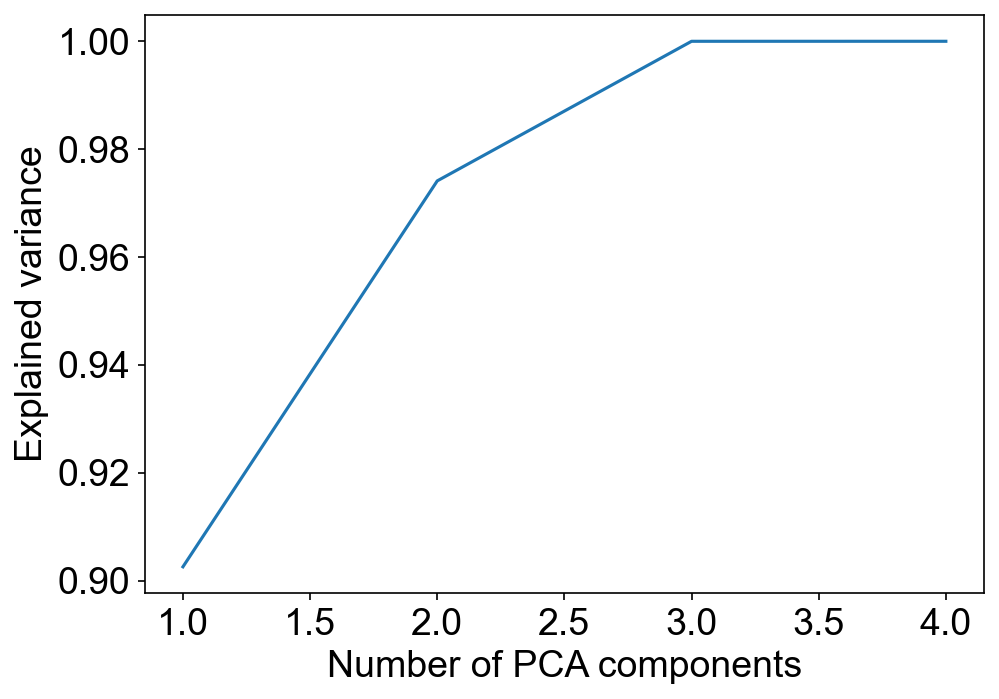

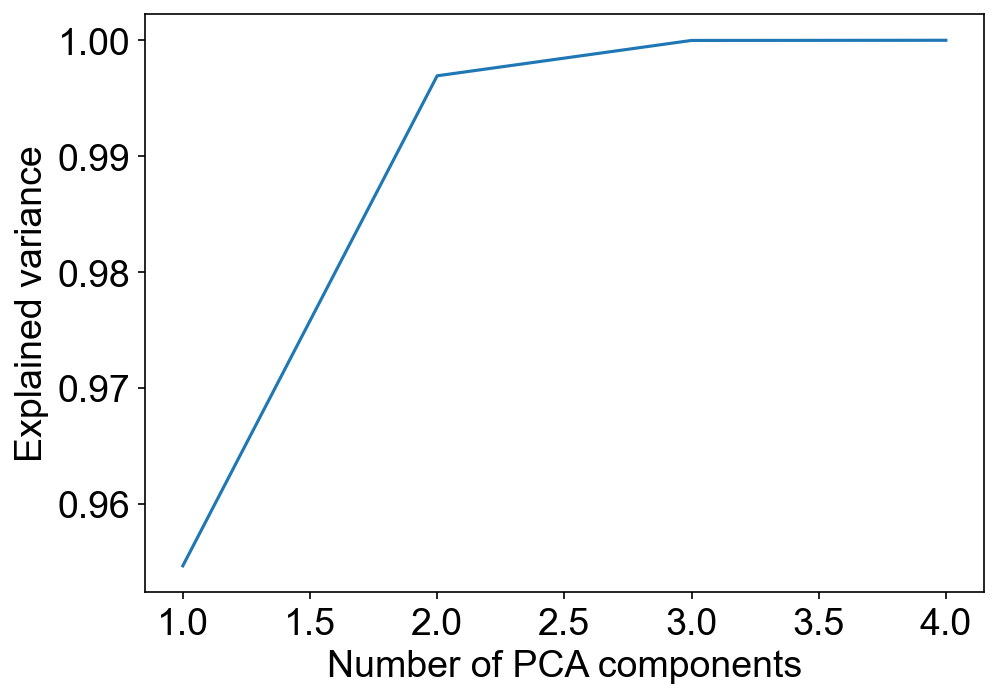

In [58]:
features = [
    "var_q_1c_c100_c10_ah",
    "form_total_lithium_consumed",
    "form_final_discharge_capacity_ah",
    "form_coulombic_efficiency",
    "dcr_10s_5_soc_at_c3",
]
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    pca = PCA()
    pca.fit(df_[features[1:]])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    fig, ax = plt.subplots()
    ax.plot(range(1,len(cumsum)+1),cumsum)
    ax.set_xlabel("Number of PCA components")
    ax.set_ylabel("Explained variance")
    fig.savefig(OUTPUT_DIR + f"pca_paper_features_{temp}.pdf")

In [59]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    out = train_and_test_model(df_, features[0], yvar70, to_plot=0, model=DummyRegressor(), num_experiments=1000)
    print(f"{'Dummy regressor (predict mean)':<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    for f in features:
        out = train_and_test_model(df_, f, yvar70, to_plot=0, model=LinearRegression(), num_experiments=1000)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features"
    out = train_and_test_model(df_, features[1:-1], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")
    f = "form features + R10s"
    out = train_and_test_model(df_, features[1:], yvar70, to_plot=0, model=Ridge(5), num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)")

hot
Dummy regressor (predict mean)                    train: 14.05 (0.87 std)		test: 14.94 (3.69 std)
var_q_1c_c100_c10_ah                              train: 10.12 (1.12 std)		test: 11.41 (4.01 std)
form_total_lithium_consumed                       train: 14.01 (0.94 std)		test: 15.90 (3.69 std)
form_final_discharge_capacity_ah                  train: 13.14 (0.87 std)		test: 14.42 (3.65 std)
form_coulombic_efficiency                         train: 13.92 (0.98 std)		test: 16.07 (3.74 std)
dcr_10s_5_soc_at_c3                               train: 6.38 (0.65 std)		test: 7.38 (2.55 std)
form features                                     train: 12.82 (0.96 std)		test: 15.23 (4.10 std)
form features + R10s                              train: 6.78 (0.49 std)		test: 8.52 (2.33 std)
room
Dummy regressor (predict mean)                    train: 13.31 (0.96 std)		test: 14.37 (3.99 std)
var_q_1c_c100_c10_ah                              train: 10.87 (1.45 std)		test: 13.26 (4.47 std)
form_total_lith

# Nested cross-validation

In [60]:
import random

def nested(df_, xvars, yvar, num_experiments=None):
    log = False
    to_plot = False

    # Number of trials
    num_experiments = num_experiments or 100

    # Unpack and filter data
    # Create a temporary df to filter NaNs only from the columns we use
    xyvars = xvars + [yvar]
    df_nonans = df_[xyvars].dropna()
    if log is True:
        df_nonans = df_nonans.apply(lambda x: np.log(abs(x)))

    percent_error_list_outer = []
    percent_error_train_list_outer = []

    for i in range(num_experiments):
#         if i%20 == 0:
#             print(i)
        df_random = df_nonans.sample(frac=1)

        # save 3 cases for validation
        validate = df_random.iloc[:3]
        train_test = df_random.iloc[3:]
        all_indices = list(range(len(train_test)))

        percent_error_list = []
        percent_error_train_list = []

        best = np.inf

        for alpha in np.logspace(-5,5,20):
            model = Ridge(alpha)
            for i in range(4):
                test = list(range(i*4,(i+1)*4))
                train = [x for x in all_indices if x not in test]
                Xy_train = train_test.iloc[train]
                Xy_test = train_test.iloc[test]

                X_train = Xy_train[xvars]
                y_train = np.array(Xy_train[yvar])
                X_test = Xy_test[xvars]
                y_test = np.array(Xy_test[yvar])

                # apply standard scaler (fit only on train, transform both train and test)
                # keep originals for pltos
            #     X_train_original = X_train
            #     X_test_original = X_test
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                (model, corr) = build_model(X_train, y_train, model)

                y_pred = model.predict(X_test)
                y_train_pred = model.predict(X_train)
            #     y_train_mean = np.mean(y_train)

            #     r2_score = model.score(X_test, y_test)

            #     if log is True:
            #         y_train = np.exp(y_train)
            #         y_pred = np.exp(y_pred)
            #         y_test = np.exp(y_test)
            #         y_train_mean = np.exp(y_train_mean)

            #     rmse = np.sqrt(np.mean((y_pred - y_test)**2))    
                percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
                percent_error_train = np.mean(np.abs(y_train_pred - y_train)/y_train) * 100
            #     baseline_rmse = np.sqrt(np.mean((y_train_mean - y_test)**2))

            #     rmse_list.append(rmse)
                percent_error_list.append(percent_error)
                percent_error_train_list.append(percent_error_train)

                #     r2_score_list.append(r2_score)
            #     baseline_rmse_list.append(baseline_rmse)
                #         intercept_list.append(model.intercept_)
                #         coef_list.append(model.coef_)
            #     corr_list.append(corr)
            score = np.mean(percent_error_list)
    #         print(score,best)
            if score < best:
                best = score
                alpha_best = alpha

        # Keep the best model
        model = Ridge(alpha_best)
        X_train = train_test[xvars]
        y_train = np.array(train_test[yvar])
        X_test = validate[xvars]
        y_test = np.array(validate[yvar])
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        (model, corr) = build_model(X_train, y_train, model)
        y_pred = model.predict(X_test)
        percent_error = np.mean(np.abs(y_pred - y_test)/y_test) * 100
        percent_error_list_outer.append(percent_error)
        y_train_pred = model.predict(X_train)
        percent_error_train = np.mean(np.abs(y_train_pred - y_train)/y_train) * 100
        percent_error_train_list_outer.append(percent_error_train)
    #     print(percent_error)
    out = {
        "percent_error_train": np.mean(percent_error_train_list_outer),
        "percent_error_train_std": np.std(percent_error_train_list_outer),
        "percent_error": np.mean(percent_error_list_outer),
        "percent_error_std": np.std(percent_error_list_outer),
        "alpha": alpha_best,
    }
    return out

# model = LinearRegression()
# xvars = form_features +c3_features
xvars = ["form_first_discharge_capacity_ah"]
out = nested(df_hot, xvars, yvar70)
print(out)


{'percent_error_train': 6.47384612734033, 'percent_error_train_std': 0.6753674394492281, 'percent_error': 7.451342466505479, 'percent_error_std': 3.4149924585663265, 'alpha': 1e-05}


In [61]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    for f in features:
        out = nested(df_, [f], yvar70, num_experiments=100)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
             + f"\t{out['alpha']}")
    f = "form features"
    out = nested(df_, features[1:-1], yvar70, num_experiments=100)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")
    f = "form features + R10s"
    out = nested(df_, features[1:], yvar70, num_experiments=100)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")

hot
var_q_1c_c100_c10_ah                              train: 10.31 (1.17 std)		test: 11.68 (4.73 std)	6.1584821106602545
form_total_lithium_consumed                       train: 14.16 (0.77 std)		test: 14.87 (4.57 std)	100000.0
form_final_discharge_capacity_ah                  train: 13.59 (0.88 std)		test: 14.37 (4.18 std)	1.8329807108324339
form_coulombic_efficiency                         train: 13.95 (0.74 std)		test: 16.05 (4.57 std)	1e-05
dcr_10s_5_soc_at_c3                               train: 6.42 (0.57 std)		test: 7.46 (2.95 std)	1e-05
form features                                     train: 13.34 (1.07 std)		test: 15.97 (4.77 std)	69.51927961775606
form features + R10s                              train: 6.62 (1.18 std)		test: 9.22 (2.79 std)	20.6913808111479
room
var_q_1c_c100_c10_ah                              train: 11.61 (1.59 std)		test: 14.33 (5.20 std)	6.1584821106602545
form_total_lithium_consumed                       train: 12.34 (1.13 std)		test: 13.44 (4.64 std)	

In [ ]:
for df_, temp in [(df_hot,"hot"), (df_room,"room")]:
    print(temp)
    for f in features:
        out = nested(df_, [f], yvar70, num_experiments=1000)
        print(f"{f:<50}"
             +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
             +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
             + f"\t{out['alpha']}")
    f = "form features"
    out = nested(df_, features[1:-1], yvar70, num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")
    f = "form features + R10s"
    out = nested(df_, features[1:], yvar70, num_experiments=1000)
    print(f"{f:<50}"
          +f"train: {out['percent_error_train']:.2f} ({out['percent_error_train_std']:.2f} std)"
          +f"\t\ttest: {out['percent_error']:.2f} ({out['percent_error_std']:.2f} std)"
         + f"\t{out['alpha']}")

hot
var_q_1c_c100_c10_ah                              train: 10.23 (1.05 std)		test: 11.58 (4.90 std)	1e-05
